In [22]:
# Install required packages
# Note: Twitter functionality removed (tweepy) - not needed for current data sources

import sys
import subprocess

def install_package(package):
    """Install a package and report success/failure"""
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", package])
        return True
    except subprocess.CalledProcessError:
        return False

# Core packages
print("Installing core packages...")
packages_core = [
    "google-play-scraper",
    "beautifulsoup4",
    "requests",
    "pandas",
    "numpy",
    "matplotlib",
    "seaborn"
]

for pkg in packages_core:
    if install_package(pkg):
        print(f"  ✓ {pkg}")
    else:
        print(f"  ✗ {pkg} (failed)")

# ML packages
print("\nInstalling ML packages...")
packages_ml = [
    "scikit-learn",
    "nltk",
    "gensim",
    "tensorflow",
    "keras",
    "wordcloud"
]

for pkg in packages_ml:
    if install_package(pkg):
        print(f"  ✓ {pkg}")
    else:
        print(f"  ✗ {pkg} (failed)")

# Data augmentation (optional but recommended)
print("\nInstalling data augmentation packages (this may take a few minutes)...")
if install_package("nlpaug"):
    print("  ✓ nlpaug")
    print("    Data augmentation available for improved accuracy!")
else:
    print("  ⚠ nlpaug installation failed")
    print("    You can continue without it, but accuracy may be lower")
    print("    To install manually: !pip install nlpaug")

print("\n" + "="*60)
print("✅ Package installation complete!")
print("="*60)


Installing core packages...
  ✓ google-play-scraper
  ✓ beautifulsoup4
  ✓ requests
  ✓ pandas
  ✓ numpy
  ✓ matplotlib
  ✓ seaborn

Installing ML packages...
  ✓ scikit-learn
  ✓ nltk
  ✓ gensim
  ✓ tensorflow
  ✓ keras
  ✓ wordcloud

Installing data augmentation packages (this may take a few minutes)...
  ✓ nlpaug
    Data augmentation available for improved accuracy!

✅ Package installation complete!


## Import Libraries

Import required libraries for data scraping, preprocessing, modeling, and evaluation.

In [23]:
# Data scraping
from google_play_scraper import reviews
from bs4 import BeautifulSoup
import requests

# Data manipulation
import pandas as pd
import numpy as np
import re
import string

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# NLP preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.utils.class_weight import compute_class_weight

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Bidirectional, BatchNormalization, Concatenate, Input, Layer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import Precision, Recall
import tensorflow.keras.backend as K
from gensim.models import Word2Vec

# Data augmentation (install with: !pip install nlpaug)
try:
    import nlpaug.augmenter.word as naw
    NLPAUG_AVAILABLE = True
except ImportError:
    NLPAUG_AVAILABLE = False
    print("Warning: nlpaug not available. Install with: pip install nlpaug")

# Utilities
import os
import warnings
warnings.filterwarnings('ignore')

# Download NLTK data
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('punkt_tab', quiet=True)

print('All libraries imported successfully!')

# Wordcloud for visualization
from wordcloud import WordCloud

# Create models directory if it doesn't exist
os.makedirs('models', exist_ok=True)
print('Models directory created/verified!')


All libraries imported successfully!
Models directory created/verified!


# 1. Data Scraping

Scrape data from **3 different apps** to create a balanced, diverse dataset:
- **Instagram** (com.instagram.android): ~8,500 reviews
- **TikTok** (com.zhiliaoapp.musically): ~8,500 reviews  
- **WhatsApp** (com.whatsapp): ~8,000 reviews

**Target**: 25,000 total samples with balanced sentiment distribution (35-37% positive, 35-37% negative, 28-32% neutral)

## 1.1 Multi-Source Playstore Reviews Scraping

Extract app reviews from 3 different apps on Google Play Store using `google-play-scraper`.
Implement class-balanced scraping to ensure equal representation of all sentiment classes.

In [ ]:
def scrape_playstore_reviews_balanced(app_id, app_name, target_count=8500):
    """
    Scrape reviews from Google Play Store with balanced sentiment distribution.
    
    Args:
        app_id: App package name (e.g., 'com.instagram.android')
        app_name: Human-readable app name for logging
        target_count: Target number of reviews to scrape
    
    Returns:
        DataFrame with review text, score, and app source
    """
    try:
        from google_play_scraper import reviews
        import random
        
        print(f"\n{'='*60}")
        print(f"Scraping {app_name} ({app_id})")
        print(f"Target: {target_count} reviews")
        print(f"{'='*60}")
        
        # Fetch more reviews than needed to allow filtering
        fetch_count = int(target_count * 1.5)
        
        print(f"Fetching {fetch_count} reviews (will filter for balance)...")
        result, _ = reviews(
            app_id,
            lang='id',
            country='id',
            count=fetch_count
        )
        
        # Extract relevant fields
        data = []
        for review in result:
            # Filter out very short or empty reviews
            content = review['content']
            if content and len(content.strip()) >= 10:  # At least 10 characters
                data.append({
                    'text': content,
                    'score': review['score'],
                    'thumbsUpCount': review.get('thumbsUpCount', 0),
                    'app_source': app_name
                })
        
        df = pd.DataFrame(data)
        
        # Analyze score distribution (proxy for sentiment)
        print(f"\nFetched {len(df)} valid reviews")
        print(f"\nScore distribution:")
        score_dist = df['score'].value_counts().sort_index()
        for score, count in score_dist.items():
            print(f"  {score} stars: {count:5d} reviews ({count/len(df)*100:5.2f}%)")
        
        # Balance by rating (as proxy for sentiment)
        # High ratings (4-5): Positive
        # Mid ratings (3): Neutral
        # Low ratings (1-2): Negative
        
        df_positive = df[df['score'] >= 4]
        df_neutral = df[df['score'] == 3]
        df_negative = df[df['score'] <= 2]
        
        # Target distribution: 37% positive, 37% negative, 26% neutral
        target_positive = int(target_count * 0.37)
        target_negative = int(target_count * 0.37)
        target_neutral = target_count - target_positive - target_negative
        
        print(f"\nBalancing sentiment distribution...")
        print(f"  Target positive (4-5★): {target_positive}")
        print(f"  Target negative (1-2★): {target_negative}")
        print(f"  Target neutral (3★): {target_neutral}")
        
        # Sample from each category
        balanced_data = []
        
        if len(df_positive) >= target_positive:
            balanced_data.append(df_positive.sample(n=target_positive, random_state=42))
        else:
            balanced_data.append(df_positive)
            print(f"  Warning: Only {len(df_positive)} positive reviews available")
        
        if len(df_negative) >= target_negative:
            balanced_data.append(df_negative.sample(n=target_negative, random_state=42))
        else:
            balanced_data.append(df_negative)
            print(f"  Warning: Only {len(df_negative)} negative reviews available")
        
        if len(df_neutral) >= target_neutral:
            balanced_data.append(df_neutral.sample(n=target_neutral, random_state=42))
        else:
            balanced_data.append(df_neutral)
            print(f"  Warning: Only {len(df_neutral)} neutral reviews available")
        
        df_balanced = pd.concat(balanced_data, ignore_index=True)
        
        # Shuffle the data
        df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
        
        print(f"\n✓ Successfully scraped and balanced {len(df_balanced)} {app_name} reviews")
        print(f"  Positive (4-5★): {len(df_balanced[df_balanced['score'] >= 4])} ({len(df_balanced[df_balanced['score'] >= 4])/len(df_balanced)*100:.1f}%)")
        print(f"  Negative (1-2★): {len(df_balanced[df_balanced['score'] <= 2])} ({len(df_balanced[df_balanced['score'] <= 2])/len(df_balanced)*100:.1f}%)")
        print(f"  Neutral (3★): {len(df_balanced[df_balanced['score'] == 3])} ({len(df_balanced[df_balanced['score'] == 3])/len(df_balanced)*100:.1f}%)")
        
        return df_balanced
    
    except Exception as e:
        print(f'Error scraping {app_name} reviews: {e}')
        print(f'Creating sample data for {app_name}...')
        return create_sample_playstore_data(app_name, target_count)

def create_sample_playstore_data(app_name='Sample', count=1000):
    """Create sample Playstore review data if scraping fails."""
    print(f"Creating {count} sample reviews for {app_name}...")
    
    sample_data = [
        {'text': 'Aplikasi ini sangat bagus dan bermanfaat!', 'score': 5, 'app_source': app_name},
        {'text': 'Saya sangat suka fitur-fiturnya', 'score': 5, 'app_source': app_name},
        {'text': 'Bagus tapi ada bug', 'score': 4, 'app_source': app_name},
        {'text': 'Biasa saja, tidak istimewa', 'score': 3, 'app_source': app_name},
        {'text': 'Tidak terlalu bagus', 'score': 2, 'app_source': app_name},
        {'text': 'Aplikasi jelek, sering crash', 'score': 1, 'app_source': app_name},
        {'text': 'Buang waktu saja', 'score': 1, 'app_source': app_name},
        {'text': 'Sempurna! Persis yang saya butuhkan', 'score': 5, 'app_source': app_name},
        {'text': 'Pengalaman yang cukup baik', 'score': 4, 'app_source': app_name},
        {'text': 'Aplikasi standar, tidak ada yang spesial', 'score': 3, 'app_source': app_name}
    ]
    
    # Repeat to reach target count
    multiplier = (count // len(sample_data)) + 1
    extended_data = (sample_data * multiplier)[:count]
    
    return pd.DataFrame(extended_data)

# Scrape from 3 different apps
print("\n" + "="*70)
print("MULTI-SOURCE DATA COLLECTION")
print("="*70)
print("\nCollecting reviews from 3 apps for diverse, balanced dataset...")

# App configurations
apps = [
    {'id': 'com.instagram.android', 'name': 'Instagram', 'target': 8500},
    {'id': 'com.zhiliaoapp.musically', 'name': 'TikTok', 'target': 8500},
    {'id': 'com.whatsapp', 'name': 'WhatsApp', 'target': 8000}
]

# Scrape from each app
all_dataframes = []
for app in apps:
    df_app = scrape_playstore_reviews_balanced(app['id'], app['name'], app['target'])
    all_dataframes.append(df_app)
    import time
    time.sleep(2)  # Be respectful to the API

# Combine all data
print(f"\n{'='*70}")
print("COMBINING DATA FROM ALL SOURCES")
print(f"{'='*70}")

playstore_df = pd.concat(all_dataframes, ignore_index=True)

# Remove duplicates (same text)
print(f"\nRemoving duplicate reviews...")
original_count = len(playstore_df)
playstore_df = playstore_df.drop_duplicates(subset=['text'], keep='first')
duplicates_removed = original_count - len(playstore_df)
print(f"  Removed {duplicates_removed} duplicate reviews")

# Shuffle combined data
playstore_df = playstore_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"\n{'='*70}")
print("FINAL MULTI-SOURCE DATASET")
print(f"{'='*70}")
print(f"Total reviews: {len(playstore_df)}")
print(f"\nReviews per app:")
for app_name, count in playstore_df['app_source'].value_counts().items():
    print(f"  {app_name}: {count} ({count/len(playstore_df)*100:.1f}%)")

print(f"\nCombined score distribution:")
for score, count in playstore_df['score'].value_counts().sort_index().items():
    print(f"  {score} stars: {count} ({count/len(playstore_df)*100:.1f}%)")

print(f"\nFirst few rows:")
print(playstore_df[['text', 'score', 'app_source']].head(10))


## 1.4 Save Raw Data

Save each dataset to separate CSV files for future use.

In [25]:
# Create data directory if it doesn't exist
os.makedirs('data', exist_ok=True)

# Save datasets
playstore_df.to_csv('data/playstore_reviews.csv', index=False)

print('All datasets saved successfully!')
print(f'  - Playstore: {len(playstore_df)} reviews')


All datasets saved successfully!
  - Playstore: 15000 reviews


# 2. Preprocessing and Cleaning

Clean and prepare data for model training.

## 2.1 Label Sentiment Classes

Convert ratings to sentiment labels: negative, neutral, positive.

In [26]:
# Enhanced Indonesian and English sentiment lexicons with stronger keywords
positive_words_strong = [
    'excellent', 'amazing', 'perfect', 'fantastic', 'wonderful', 'brilliant', 'outstanding',
    'hebat', 'sempurna', 'luar biasa', 'fantastis', 'terbaik', 'sangat bagus', 'mantap sekali',
    'loved', 'love', 'best', 'awesome', 'great'
]

negative_words_strong = [
    'terrible', 'horrible', 'worst', 'awful', 'useless', 'garbage', 'trash', 'hate',
    'buruk sekali', 'sangat buruk', 'terburuk', 'jelek sekali', 'sampah', 'payah',
    'benci', 'kecewa sekali', 'mengecewakan'
]

positive_words = [
    # Indonesian positive words
    'bagus', 'baik', 'hebat', 'mantap', 'keren', 'sempurna', 'terbaik', 'suka',
    'senang', 'puas', 'memuaskan', 'recommended', 'lancar', 'cepat', 'mudah',
    'berguna', 'membantu', 'cocok', 'nyaman', 'aman', 'jelas', 'lengkap',
    'canggih', 'modern', 'inovatif', 'praktis', 'efisien', 'handal', 'stabil',
    'menarik', 'kualitas', 'profesional', 'responsif', 'luar', 'biasa',
    'istimewa', 'menakjubkan', 'mengagumkan', 'indah', 'cantik', 'elegan',
    'mewah', 'premium', 'top', 'unggul', 'juara', 'setuju', 'mendukung',
    'positif', 'optimis', 'harapan', 'berhasil', 'sukses', 'pintar', 'cerdas',
    'brilian', 'genius', 'kreatif', 'revolusioner', 'terobosan', 'fresh',
    'baru', 'segar', 'menyenangkan', 'menggembirakan', 'membahagiakan',
    'menghibur', 'ramah', 'sopan', 'murah', 'terjangkau', 'worthit',
    'rekomendasi', 'recommend', 'sarankan', 'pilihan', 'favorit', 'terpercaya',
    # English positive words
    'good', 'great', 'excellent', 'amazing', 'awesome', 'wonderful', 'fantastic',
    'perfect', 'best', 'brilliant', 'outstanding', 'superb', 'terrific', 'fabulous',
    'love', 'like', 'enjoy', 'happy', 'satisfied', 'pleased', 'glad', 'delighted',
    'helpful', 'useful', 'easy', 'simple', 'fast', 'quick', 'smooth', 'reliable',
    'stable', 'comfortable', 'convenient', 'efficient', 'effective', 'impressive',
    'beautiful', 'nice', 'pretty', 'attractive', 'elegant', 'sleek', 'clean',
    'clear', 'friendly', 'affordable', 'cheap', 'worth', 'recommend', 'perfect'
]

negative_words = [
    # Indonesian negative words
    'buruk', 'jelek', 'parah', 'payah', 'kecewa', 'mengecewakan', 'gagal', 'error',
    'lemot', 'lambat', 'rusak', 'hancur', 'bodoh', 'tolol', 'goblok', 'sampah',
    'benci', 'bosan', 'marah', 'kesal', 'jengkel', 'dongkol', 'sebal', 'muak',
    'menyebalkan', 'menjengkelkan', 'mengganggu', 'merusak', 'merugikan',
    'susah', 'sulit', 'ribet', 'rumit', 'membingungkan', 'tidak jelas',
    'tidak berguna', 'tidak berfungsi', 'tidak bekerja', 'tidak bisa',
    'masalah', 'bug', 'crash', 'hang', 'freeze', 'lag', 'delay',
    'penipuan', 'bohong', 'tipu', 'palsu', 'tidak aman', 'berbahaya', 'bahaya',
    'mahal', 'boros', 'tidak worth', 'tidak recommended', 'jangan', 'tidak',
    # English negative words
    'bad', 'poor', 'terrible', 'horrible', 'awful', 'worst', 'disappointing',
    'disappointed', 'useless', 'worthless', 'fail', 'failed', 'failure', 'broken',
    'hate', 'dislike', 'angry', 'annoying', 'annoyed', 'frustrated', 'frustrating',
    'difficult', 'hard', 'complicated', 'confusing', 'unclear', 'misleading',
    'slow', 'sluggish', 'crash', 'freeze', 'bug', 'error', 'issue', 'problem',
    'scam', 'fraud', 'fake', 'dangerous', 'unsafe', 'expensive', 'waste', 'garbage'
]

# Negation patterns (Indonesian and English)
negation_patterns = [
    r'\btidak\s+(\w+)',
    r'\bbukan\s+(\w+)',
    r'\bjangan\s+(\w+)',
    r'\bnot\s+(\w+)',
    r'\bno\s+(\w+)',
    r"\bdon't\s+(\w+)",
    r"\bdoesn't\s+(\w+)",
    r"\bwon't\s+(\w+)",
    r"\bcan't\s+(\w+)",
]

def advanced_sentiment_labeling(row):
    """
    Advanced context-aware sentiment labeling with:
    - Strong positive/negative keyword detection
    - Text sentiment override when very clear
    - Negation pattern detection
    - Text length consideration for edge cases
    """
    text = str(row['text']).lower() if pd.notna(row['text']) else ''
    score = row['score']

    # Count strong sentiment keywords
    strong_positive_count = sum(1 for word in positive_words_strong if word in text)
    strong_negative_count = sum(1 for word in negative_words_strong if word in text)

    # Count regular sentiment keywords
    positive_count = sum(1 for word in positive_words if word in text)
    negative_count = sum(1 for word in negative_words if word in text)

    # Check for negation patterns
    has_negation = any(re.search(pattern, text) for pattern in negation_patterns)

    # Text length (very short texts are harder to classify)
    text_length = len(text.split())

    # Strong override: If text has strong sentiment keywords, override score
    if strong_positive_count >= 2 and strong_negative_count == 0:
        return 'positive'
    if strong_negative_count >= 2 and strong_positive_count == 0:
        return 'negative'

    # Clear sentiment override based on keyword counts
    if positive_count >= 3 and negative_count == 0 and not has_negation:
        return 'positive'
    if negative_count >= 3 and positive_count == 0:
        return 'negative'

    # Handle negation cases
    if has_negation:
        if positive_count > negative_count:
            # Negation + positive words = negative
            return 'negative'

    # Score-based classification with text analysis refinement
    if score >= 4:
        # High score but negative words - check context
        if negative_count > positive_count and negative_count >= 2:
            return 'neutral'  # Mixed sentiment
        return 'positive'
    elif score <= 2:
        # Low score but positive words - check context
        if positive_count > negative_count and positive_count >= 2:
            return 'neutral'  # Mixed sentiment
        return 'negative'
    else:  # score == 3
        # Neutral score - use text analysis
        if positive_count > negative_count + 1:
            return 'positive'
        elif negative_count > positive_count + 1:
            return 'negative'
        else:
            # True neutral or very short text
            if text_length < 3:
                # Very short neutral texts might not be informative
                return 'neutral'
            return 'neutral'

print('Advanced sentiment labeling function defined!')


Advanced sentiment labeling function defined!


## 2.2 Text Cleaning Functions

Define comprehensive text cleaning functions for preprocessing.

In [27]:
# Ensure NLP tools are initialized
if 'stemmer' not in globals():
    stemmer = PorterStemmer()
if 'lemmatizer' not in globals():
    lemmatizer = WordNetLemmatizer()
if 'stop_words' not in globals():
    # Combine Indonesian and English stopwords
    indonesian_stopwords = set([
        'yang', 'di', 'ke', 'dari', 'dan', 'untuk', 'dengan', 'pada', 'dalam', 'ini',
        'itu', 'adalah', 'atau', 'juga', 'akan', 'telah', 'ada', 'dapat', 'sudah',
        'seperti', 'saya', 'kamu', 'dia', 'kami', 'mereka', 'nya', 'satu', 'dua',
        'si', 'bisa', 'ya', 'apa', 'karena', 'jika', 'kalau', 'oleh',
        'antara', 'sebagai', 'saat', 'ketika', 'sebelum', 'sesudah', 'hingga',
        'bahwa', 'hanya', 'semua', 'setiap', 'lebih', 'paling', 'lagi', 'masih'
    ])
    try:
        english_stopwords = set(stopwords.words('english'))
    except:
        english_stopwords = set()
    stop_words = indonesian_stopwords.union(english_stopwords)

# Indonesian slang normalization dictionary
slang_dict = {
    'gak': 'tidak', 'ga': 'tidak', 'ngga': 'tidak', 'gk': 'tidak',
    'udah': 'sudah', 'udh': 'sudah', 'dah': 'sudah',
    'emang': 'memang', 'emg': 'memang',
    'banget': 'sangat', 'bgt': 'sangat', 'bngtt': 'sangat',
    'tp': 'tetapi', 'tapi': 'tetapi',
    'yg': 'yang', 'yng': 'yang',
    'krn': 'karena', 'krna': 'karena',
    'dgn': 'dengan', 'dng': 'dengan',
    'utk': 'untuk', 'tuk': 'untuk',
    'jd': 'jadi', 'jdi': 'jadi',
    'sy': 'saya', 'gw': 'saya', 'gue': 'saya', 'aku': 'saya',
    'km': 'kamu', 'kmu': 'kamu', 'lu': 'kamu', 'elu': 'kamu',
    'org': 'orang', 'orng': 'orang',
    'trs': 'terus', 'trus': 'terus',
    'kyk': 'seperti', 'kyak': 'seperti',
    'skrg': 'sekarang', 'skr': 'sekarang',
    'bs': 'bisa', 'bsa': 'bisa',
    'blm': 'belum', 'blom': 'belum',
    'gmn': 'bagaimana', 'gimana': 'bagaimana',
    'knp': 'kenapa', 'knapa': 'kenapa',
    'krg': 'kurang', 'kurng': 'kurang',
    'byk': 'banyak', 'bnyk': 'banyak',
    'msh': 'masih', 'msih': 'masih',
    'hrs': 'harus', 'hrus': 'harus',
    'sdh': 'sudah', 'tlh': 'telah',
    'dlm': 'dalam', 'pd': 'pada',
    'tdk': 'tidak', 'blh': 'boleh',
    'mantap': 'mantap', 'mantul': 'mantap', 'manteb': 'mantap',
    'keren': 'keren', 'kerenn': 'keren', 'kerennnn': 'keren',
    'jelek': 'jelek', 'jlek': 'jelek', 'jeleq': 'jelek',
    'bagus': 'bagus', 'bgs': 'bagus', 'baguus': 'bagus',
}

def normalize_slang(text):
    """Normalize Indonesian slang to formal words"""
    words = text.split()
    normalized = [slang_dict.get(word, word) for word in words]
    return ' '.join(normalized)

def remove_repeated_chars(text):
    """
    Remove repeated characters (e.g., 'mantaaap' -> 'mantap', 'baguuus' -> 'bagus')
    Keep maximum 2 repeated characters
    """
    # Pattern: replace 3+ repeated characters with 2
    return re.sub(r'(.)\1{2,}', r'\1\1', text)

def enhanced_clean_text(text, remove_stopwords=True, use_stemming=False, use_lemmatization=False):
    """
    Enhanced text cleaning with:
    - Indonesian slang normalization
    - Repeated character handling
    - Standard cleaning (lowercase, punctuation, etc.)
    """
    if pd.isna(text):
        return ''

    # Convert to lowercase
    text = str(text).lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)

    # Remove mentions and hashtags
    text = re.sub(r'@\w+|#\w+', '', text)

    # Remove numbers but keep words with numbers
    text = re.sub(r'\b\d+\b', '', text)

    # Remove repeated characters (e.g., 'mantaaap' -> 'mantap')
    text = remove_repeated_chars(text)

    # Normalize Indonesian slang
    text = normalize_slang(text)

    # Remove punctuation except for sentiment-relevant ones temporarily
    # We'll handle them in feature extraction
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Tokenization
    tokens = word_tokenize(text)

    # Remove stopwords if specified
    if remove_stopwords:
        tokens = [word for word in tokens if word not in stop_words and len(word) > 2]

    # Stemming
    if use_stemming:
        tokens = [stemmer.stem(word) for word in tokens]

    # Lemmatization
    if use_lemmatization:
        tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)

print('Enhanced text cleaning functions defined!')


Enhanced text cleaning functions defined!


## 2.3 Apply Cleaning to Datasets

Clean datasets with deduplication and text preprocessing.

In [28]:
def preprocess_dataset(df, text_column='text'):
    """Preprocess dataset with enhanced cleaning and deduplication."""
    # Create a copy
    df_clean = df.copy()

    # Remove duplicates
    initial_count = len(df_clean)
    df_clean = df_clean.drop_duplicates(subset=[text_column])
    print(f'Removed {initial_count - len(df_clean)} duplicate entries')

    # Remove null/empty texts
    df_clean = df_clean[df_clean[text_column].notna()]
    df_clean = df_clean[df_clean[text_column].str.strip() != '']

    # Apply advanced sentiment labeling
    df_clean['sentiment'] = df_clean.apply(advanced_sentiment_labeling, axis=1)

    # Clean text using enhanced cleaning function
    print('Cleaning text with enhanced preprocessing...')
    df_clean['cleaned_text'] = df_clean[text_column].apply(
        lambda x: enhanced_clean_text(x, remove_stopwords=True, use_stemming=False, use_lemmatization=False)
    )

    # Remove entries with empty cleaned text
    df_clean = df_clean[df_clean['cleaned_text'].str.strip() != '']

    print(f'Final dataset size: {len(df_clean)} entries')
    print(f'Sentiment distribution:')
    print(df_clean['sentiment'].value_counts())
    print(f'Sentiment percentages:')
    print(df_clean['sentiment'].value_counts(normalize=True) * 100)

    return df_clean

print('Enhanced preprocessing function defined!')


Enhanced preprocessing function defined!


In [ ]:
# Apply preprocessing
playstore_clean = preprocess_dataset(playstore_df, text_column='text')


## 2.4 Encode Sentiment Labels

Convert sentiment labels to numerical format for model training.

In [29]:
from sklearn.preprocessing import LabelEncoder

# Create label encoder
label_encoder = LabelEncoder()

# Encode labels using 'sentiment_encoded' column
playstore_clean['sentiment_encoded'] = label_encoder.fit_transform(playstore_clean['sentiment'])

# Display label mapping
print('Label mapping:')
for i, label in enumerate(label_encoder.classes_):
    print(f'  {label}: {i}')

# Save cleaned datasets
playstore_clean.to_csv('data/playstore_cleaned.csv', index=False)

print('\nCleaned datasets saved!')
print(f"Dataset shape: {playstore_clean.shape}")
print(f"\nColumns: {playstore_clean.columns.tolist()}")
print(f"\nClass distribution:")
print(playstore_clean['sentiment'].value_counts())


Label mapping:
  negative: 0
  neutral: 1
  positive: 2

Cleaned datasets saved!
Dataset shape: (10759, 7)

Columns: ['text', 'score', 'thumbsUpCount', 'sentiment', 'cleaned_text', 'label', 'sentiment_encoded']

Class distribution:
sentiment
positive    6577
negative    3759
neutral      423
Name: count, dtype: int64


## 2.5 Data Augmentation for Class Balancing

In [30]:
def augment_minority_classes(df, target_column='sentiment', text_column='cleaned_text',
                              target_ratio=0.5, use_backtranslation=False):
    """
    Augment minority classes to balance dataset.
    Target: Each minority class should be at least target_ratio * majority class size

    Args:
        df: DataFrame with text and sentiment
        target_column: Column name for sentiment labels
        text_column: Column name for text data
        target_ratio: Target ratio of minority to majority class (0.5 = 50%)
        use_backtranslation: Whether to use back-translation (slower but better quality)

    Returns:
        Augmented DataFrame
    """
    if not NLPAUG_AVAILABLE:
        print("Warning: nlpaug not available. Skipping augmentation.")
        print("Install with: !pip install nlpaug")
        return df

    print("Starting data augmentation for class balancing...")

    # Get class distribution
    class_counts = df[target_column].value_counts()
    print(f"\nOriginal class distribution:")
    print(class_counts)

    majority_class = class_counts.idxmax()
    majority_count = class_counts.max()
    target_count = int(majority_count * target_ratio)

    print(f"\nMajority class: {majority_class} ({majority_count} samples)")
    print(f"Target count for minority classes: {target_count} samples")

    # Initialize augmenters
    # Synonym replacement augmenter
    syn_aug = naw.SynonymAug(aug_src='wordnet')

    # Back-translation augmenter (optional, slower)
    if use_backtranslation:
        try:
            back_aug = naw.BackTranslationAug(
                from_model_name='facebook/wmt19-en-de',
                to_model_name='facebook/wmt19-de-en'
            )
        except:
            print("Back-translation models not available, using synonym only")
            back_aug = None
    else:
        back_aug = None

    augmented_data = []

    # Augment each minority class
    for class_label in class_counts.index:
        if class_label == majority_class:
            continue

        current_count = class_counts[class_label]

        if current_count >= target_count:
            print(f"\nClass '{class_label}': {current_count} samples (no augmentation needed)")
            continue

        samples_needed = target_count - current_count
        print(f"\nClass '{class_label}': {current_count} samples, augmenting {samples_needed} more...")

        # Get samples from this class
        class_samples = df[df[target_column] == class_label]

        # Augment samples
        augmented_count = 0
        iterations = 0
        max_iterations = samples_needed * 3  # Prevent infinite loop

        while augmented_count < samples_needed and iterations < max_iterations:
            # Randomly select a sample
            sample = class_samples.sample(n=1).iloc[0]
            original_text = sample[text_column]

            # Skip very short texts
            if len(original_text.split()) < 3:
                iterations += 1
                continue

            try:
                # Apply augmentation
                if back_aug and augmented_count % 2 == 0:  # Use back-translation for 50% if available
                    augmented_text = back_aug.augment(original_text)
                else:
                    augmented_text = syn_aug.augment(original_text)

                # Handle list output from augmenter
                if isinstance(augmented_text, list):
                    augmented_text = augmented_text[0]

                # Check if augmentation actually changed the text
                if augmented_text != original_text and len(augmented_text.split()) >= 3:
                    # Create new augmented sample
                    new_sample = sample.copy()
                    new_sample[text_column] = augmented_text
                    augmented_data.append(new_sample)
                    augmented_count += 1

                    if augmented_count % 50 == 0:
                        print(f"  Generated {augmented_count}/{samples_needed} samples...")

            except Exception as e:
                # Skip samples that cause errors
                pass

            iterations += 1

        print(f"  Completed: Generated {augmented_count} augmented samples for '{class_label}'")

    # Combine original and augmented data
    if augmented_data:
        augmented_df = pd.DataFrame(augmented_data)
        df_balanced = pd.concat([df, augmented_df], ignore_index=True)

        print(f"\n{'='*60}")
        print("Augmentation complete!")
        print(f"Original size: {len(df)}")
        print(f"Augmented size: {len(df_balanced)}")
        print(f"Added samples: {len(augmented_df)}")
        print(f"\nNew class distribution:")
        print(df_balanced[target_column].value_counts())
        print(f"\nNew class percentages:")
        print(df_balanced[target_column].value_counts(normalize=True) * 100)
        print(f"{'='*60}")

        return df_balanced
    else:
        print("\nNo augmentation was performed.")
        return df

print('Data augmentation function defined!')


Data augmentation function defined!


## 2.7 Execute Data Augmentation

Apply data augmentation to balance the dataset, especially for underrepresented classes.

In [ ]:
# Note: This cell will be executed after preprocessing
# The actual augmentation will be applied in the preprocessing section
print('Data augmentation will be applied during preprocessing...')
print('Augmentation strategy:')
print('  - Target: Balance minority classes to 50% of majority class')
print('  - Method: Synonym replacement using nlpaug')
print('  - Focus: Neutral and underrepresented classes')


## 2.6 Feature Engineering

In [31]:
def extract_additional_features(df, text_column='text'):
    """
    Extract sentiment-relevant features from text:
    - Text length (characters and words)
    - Punctuation counts (exclamation, question marks)
    - Capitalization ratio
    - Positive/negative word counts

    Returns DataFrame with additional feature columns
    """
    print("Extracting additional features...")

    df_features = df.copy()

    # Text length features
    df_features['text_length'] = df_features[text_column].apply(lambda x: len(str(x)))
    df_features['word_count'] = df_features[text_column].apply(lambda x: len(str(x).split()))

    # Punctuation features
    df_features['exclamation_count'] = df_features[text_column].apply(
        lambda x: str(x).count('!')
    )
    df_features['question_count'] = df_features[text_column].apply(
        lambda x: str(x).count('?')
    )
    df_features['punctuation_count'] = df_features[text_column].apply(
        lambda x: sum(1 for c in str(x) if c in string.punctuation)
    )

    # Capitalization ratio (all caps words often indicate strong emotion)
    def get_caps_ratio(text):
        words = str(text).split()
        if len(words) == 0:
            return 0
        caps_words = sum(1 for word in words if word.isupper() and len(word) > 1)
        return caps_words / len(words)

    df_features['caps_ratio'] = df_features[text_column].apply(get_caps_ratio)

    # Sentiment word counts
    def count_sentiment_words(text):
        text_lower = str(text).lower()
        pos_count = sum(1 for word in positive_words if word in text_lower)
        neg_count = sum(1 for word in negative_words if word in text_lower)
        return pos_count, neg_count

    sentiment_counts = df_features[text_column].apply(count_sentiment_words)
    df_features['positive_word_count'] = sentiment_counts.apply(lambda x: x[0])
    df_features['negative_word_count'] = sentiment_counts.apply(lambda x: x[1])
    df_features['sentiment_word_ratio'] = df_features.apply(
        lambda row: (row['positive_word_count'] - row['negative_word_count']) /
                    max(row['word_count'], 1), axis=1
    )

    print("\nFeature extraction complete!")
    print(f"Added features: {['text_length', 'word_count', 'exclamation_count', 'question_count', 'punctuation_count', 'caps_ratio', 'positive_word_count', 'negative_word_count', 'sentiment_word_ratio']}")
    print(f"\nFeature statistics:")
    feature_cols = ['text_length', 'word_count', 'exclamation_count', 'question_count',
                    'caps_ratio', 'positive_word_count', 'negative_word_count', 'sentiment_word_ratio']
    print(df_features[feature_cols].describe())

    return df_features

print('Feature engineering function defined!')


Feature engineering function defined!


# 3. Model Training - 6 Advanced Models

Train and evaluate 6 different models with comprehensive techniques:

1. **Baseline Logistic Regression**: Basic TF-IDF + LR with class_weight='balanced'
2. **Optimized Logistic Regression**: Enhanced features + GridSearchCV hyperparameter tuning
3. **Basic LSTM**: Standard LSTM with 128 units, dropout 0.3
4. **Bidirectional LSTM**: Enhanced BiLSTM with batch normalization and L2 regularization
5. **Multi-Filter CNN**: 1D CNN with multiple kernel sizes [3,4,5] and global max pooling
6. **Ensemble Model**: Soft voting ensemble combining best models OR CNN-LSTM hybrid

Each model uses:
- Class weighting for imbalanced data
- Early stopping and learning rate reduction
- Cross-validation for robustness
- Comprehensive evaluation metrics

## 3.1 Prepare Data Splits

Create train-test splits with both 80/20 and 70/30 ratios.

In [32]:
def prepare_data_splits(df, split_ratio=0.8):
    """Prepare train-test splits from preprocessed data with class weights."""
    from sklearn.model_selection import train_test_split

    X = df['cleaned_text'].values
    y = df['sentiment_encoded'].values

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=(1-split_ratio), random_state=42, stratify=y
    )

    print(f'Training set size: {len(X_train)}')
    print(f'Test set size: {len(X_test)}')
    print(f'Training set distribution: {np.bincount(y_train)}')
    print(f'Test set distribution: {np.bincount(y_test)}')

    return X_train, X_test, y_train, y_test

def calculate_class_weights(y_train):
    """
    Calculate class weights for imbalanced datasets.
    This helps the model pay more attention to minority classes.
    """
    classes = np.unique(y_train)
    weights = compute_class_weight('balanced', classes=classes, y=y_train)
    class_weight_dict = dict(zip(classes, weights))

    print("\nClass weights calculated:")
    for class_idx, weight in class_weight_dict.items():
        print(f"  Class {class_idx}: {weight:.3f}")

    return class_weight_dict

def get_advanced_callbacks(model_name, monitor='val_accuracy', save_dir='models'):
    """
    Get advanced callbacks for model training:
    - EarlyStopping: Stop training when validation accuracy stops improving
    - ReduceLROnPlateau: Reduce learning rate when stuck
    - ModelCheckpoint: Save best model
    """
    os.makedirs(save_dir, exist_ok=True)

    callbacks = [
        EarlyStopping(
            monitor=monitor,
            patience=15,
            verbose=1,
            mode='max',
            restore_best_weights=True
        ),
        ReduceLROnPlateau(
            monitor=monitor,
            factor=0.5,
            patience=5,
            verbose=1,
            mode='max',
            min_lr=1e-7
        ),
        ModelCheckpoint(
            filepath=os.path.join(save_dir, f'{model_name}_best.h5'),
            monitor=monitor,
            save_best_only=True,
            mode='max',
            verbose=1
        )
    ]

    print(f"Callbacks configured for {model_name}:")
    print(f"  - Early stopping (patience=15)")
    print(f"  - Learning rate reduction (factor=0.5, patience=5)")
    print(f"  - Model checkpoint (save to {save_dir})")

    return callbacks

print('Data preparation and callback functions defined!')


Data preparation and callback functions defined!


## 3.2 Model 1: Baseline Logistic Regression

Train baseline Logistic Regression with TF-IDF and class_weight='balanced'.

In [ ]:
def train_logistic_regression(X_train, X_test, y_train, y_test, dataset_name='Dataset'):
    """
    Train baseline Logistic Regression model.
    
    Args:
        X_train, X_test: Feature matrices
        y_train, y_test: Target labels
        dataset_name: Name for reporting
    
    Returns:
        Dictionary with model, predictions, and metrics
    """
    print(f"\nTraining baseline Logistic Regression on {dataset_name}...")
    
    # Train model with basic settings
    model = LogisticRegression(
        max_iter=1000,
        random_state=42,
        multi_class='multinomial',
        solver='lbfgs'
    )
    
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    
    return {
        'model': model,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'dataset': dataset_name
    }

print('Baseline Logistic Regression function defined!')


In [33]:
def train_improved_logistic_regression(X_train, X_test, y_train, y_test, dataset_name=''):
    """
    Train improved Logistic Regression with:
    - TF-IDF with larger vocabulary and trigrams
    - ElasticNet regularization
    - Class balancing
    """
    print(f"\n{'='*60}")
    print(f"Training Improved Logistic Regression - {dataset_name}")
    print(f"{'='*60}")

    # Enhanced TF-IDF Vectorizer
    print("\nVectorizing with enhanced TF-IDF...")
    print("  - max_features: 10000 (larger vocabulary)")
    print("  - ngram_range: (1,3) (unigrams, bigrams, trigrams)")
    print("  - sublinear_tf: True (log scaling)")

    vectorizer = TfidfVectorizer(
        max_features=10000,
        ngram_range=(1, 3),
        sublinear_tf=True,
        min_df=2,
        max_df=0.95
    )

    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)

    print(f"\nTF-IDF matrix shape:")
    print(f"  Training: {X_train_tfidf.shape}")
    print(f"  Testing: {X_test_tfidf.shape}")

    # Train improved Logistic Regression with ElasticNet
    print("\nTraining Logistic Regression...")
    print("  - solver: saga (supports ElasticNet)")
    print("  - penalty: elasticnet (L1 + L2 regularization)")
    print("  - l1_ratio: 0.5 (balanced L1/L2)")
    print("  - class_weight: balanced")
    print("  - max_iter: 1000")

    model = LogisticRegression(
        solver='saga',
        penalty='elasticnet',
        l1_ratio=0.5,
        class_weight='balanced',
        max_iter=1000,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )

    import time
    start_time = time.time()
    model.fit(X_train_tfidf, y_train)
    training_time = time.time() - start_time

    # Predictions
    y_pred = model.predict(X_test_tfidf)
    y_pred_proba = model.predict_proba(X_test_tfidf)

    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    print(f"\n{'='*60}")
    print(f"RESULTS - Improved Logistic Regression - {dataset_name}")
    print(f"{'='*60}")
    print(f"Training time: {training_time:.2f} seconds")
    print(f"Test Accuracy:  {accuracy*100:.2f}%")
    print(f"Test Precision: {precision*100:.2f}%")
    print(f"Test Recall:    {recall*100:.2f}%")
    print(f"Test F1-Score:  {f1*100:.2f}%")
    print(f"{'='*60}")

    # Per-class metrics
    print(f"\nPer-class metrics:")
    print(classification_report(y_test, y_pred, zero_division=0))

    return {
        'model': model,
        'vectorizer': vectorizer,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'predictions': y_pred,
        'y_pred_proba': y_pred_proba,
        'training_time': training_time
    }

print('Improved Logistic Regression function defined!')



Improved Logistic Regression function defined!


## 3.3 Model 2: Optimized Logistic Regression with GridSearchCV

Enhanced Logistic Regression with:
- Additional engineered features (text length, sentiment word counts, etc.)
- GridSearchCV for hyperparameter optimization
- Optimized C and penalty parameters

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from scipy.sparse import hstack, csr_matrix
import time

def train_optimized_logistic_regression(X_train, X_test, y_train, y_test, 
                                       X_train_features=None, X_test_features=None,
                                       dataset_name='', use_gridsearch=True):
    """
    Train optimized Logistic Regression with GridSearchCV and additional features.
    
    Args:
        X_train, X_test: Text data
        y_train, y_test: Labels
        X_train_features, X_test_features: Additional engineered features (optional)
        dataset_name: Name for logging
        use_gridsearch: Whether to use GridSearchCV (slower but better)
    
    Returns:
        Dictionary with model, vectorizer, and metrics
    """
    print(f"\n{'='*60}")
    print(f"Training Optimized Logistic Regression - {dataset_name}")
    print(f"{'='*60}")
    
    # TF-IDF Vectorization with optimized parameters
    print("\nVectorizing text with TF-IDF (enhanced parameters)...")
    vectorizer = TfidfVectorizer(
        max_features=15000,  # More features than baseline
        ngram_range=(1, 3),   # Uni, bi, and trigrams
        min_df=2,
        max_df=0.9,
        sublinear_tf=True
    )
    
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)
    
    print(f"  TF-IDF matrix shape: {X_train_tfidf.shape}")
    
    # Combine with additional features if provided
    if X_train_features is not None and X_test_features is not None:
        print("\nCombining TF-IDF with additional engineered features...")
        X_train_combined = hstack([X_train_tfidf, csr_matrix(X_train_features)])
        X_test_combined = hstack([X_test_tfidf, csr_matrix(X_test_features)])
        print(f"  Combined matrix shape: {X_train_combined.shape}")
    else:
        X_train_combined = X_train_tfidf
        X_test_combined = X_test_tfidf
    
    # Calculate class weights
    class_weights = calculate_class_weights(y_train)
    
    start_time = time.time()
    
    if use_gridsearch:
        print("\nPerforming GridSearchCV for hyperparameter optimization...")
        print("  Testing combinations of C and penalty...")
        
        param_grid = {
            'C': [0.1, 0.5, 1.0, 2.0, 5.0],
            'penalty': ['l2'],
            'solver': ['lbfgs', 'saga'],
            'max_iter': [500]
        }
        
        lr = LogisticRegression(class_weight='balanced', random_state=42)
        
        grid_search = GridSearchCV(
            lr,
            param_grid,
            cv=3,
            scoring='f1_weighted',
            n_jobs=-1,
            verbose=1
        )
        
        grid_search.fit(X_train_combined, y_train)
        
        print(f"\n  Best parameters: {grid_search.best_params_}")
        print(f"  Best CV F1-score: {grid_search.best_score_:.4f}")
        
        model = grid_search.best_estimator_
        
    else:
        print("\nTraining with default optimized parameters...")
        model = LogisticRegression(
            C=1.0,
            penalty='l2',
            solver='lbfgs',
            max_iter=500,
            class_weight='balanced',
            random_state=42
        )
        model.fit(X_train_combined, y_train)
    
    training_time = time.time() - start_time
    
    # Predictions
    y_pred = model.predict(X_test_combined)
    y_pred_proba = model.predict_proba(X_test_combined)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    
    print(f"\n{'='*60}")
    print(f"RESULTS - Optimized Logistic Regression - {dataset_name}")
    print(f"{'='*60}")
    print(f"Training time: {training_time:.2f} seconds")
    print(f"Test Accuracy:  {accuracy*100:.2f}%")
    print(f"Test Precision: {precision*100:.2f}%")
    print(f"Test Recall:    {recall*100:.2f}%")
    print(f"Test F1-Score:  {f1*100:.2f}%")
    print(f"{'='*60}")
    
    # Per-class metrics
    print(f"\nPer-class metrics:")
    print(classification_report(y_test, y_pred, zero_division=0))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nConfusion Matrix:")
    print(cm)
    
    return {
        'model': model,
        'vectorizer': vectorizer,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'predictions': y_pred,
        'y_pred_proba': y_pred_proba,
        'training_time': training_time,
        'confusion_matrix': cm
    }

print('Optimized Logistic Regression function defined!')



## 3.4 Model 3: Basic LSTM

Train basic LSTM with standard architecture (128 units, dropout 0.3).

In [ ]:
def train_basic_lstm(X_train, X_test, y_train, y_test, vocab_size, max_length=200, dataset_name='Dataset'):
    """
    Train basic LSTM model with standard architecture.
    
    Args:
        X_train, X_test: Padded sequences
        y_train, y_test: Target labels
        vocab_size: Size of vocabulary
        max_length: Maximum sequence length
        dataset_name: Name for reporting
    
    Returns:
        Dictionary with model, predictions, and metrics
    """
    print(f"\nTraining Basic LSTM on {dataset_name}...")
    
    # Determine number of classes
    num_classes = len(np.unique(y_train))
    
    # Build model
    model = Sequential([
        Embedding(vocab_size, 128, input_length=max_length),
        LSTM(128, dropout=0.2, recurrent_dropout=0.2),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
    )
    
    # Callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    )
    
    # Train model
    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=10,
        batch_size=32,
        callbacks=[early_stopping],
        verbose=0
    )
    
    # Make predictions
    y_pred_proba = model.predict(X_test, verbose=0)
    y_pred = np.argmax(y_pred_proba, axis=1)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    
    return {
        'model': model,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'history': history.history,
        'dataset': dataset_name
    }

def build_bidirectional_lstm_with_attention(vocab_size, embedding_dim=128, max_length=200, num_classes=3):
    """
    Build Bidirectional LSTM with Attention mechanism.
    """
    print(f"Building BiLSTM with Attention (vocab_size={vocab_size}, embedding_dim={embedding_dim})...")
    
    # Input layer
    inputs = Input(shape=(max_length,))
    
    # Embedding layer
    x = Embedding(vocab_size, embedding_dim, input_length=max_length)(inputs)
    
    # Bidirectional LSTM
    lstm_out = Bidirectional(LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))(x)
    
    # Attention layer
    attention_out = AttentionLayer()(lstm_out)
    
    # Dense layers
    x = Dense(64, activation='relu')(attention_out)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
    )
    
    return model

print('Basic LSTM and BiLSTM functions defined!')


## 3.5 Model 4: Bidirectional LSTM with Attention

Advanced BiLSTM with attention mechanism for improved context understanding.


In [34]:
# Define Attention Layer
class AttentionLayer(Layer):
    """
    Attention mechanism layer for neural networks.
    Helps the model focus on important parts of the input sequence.
    """
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(
            name='attention_weight',
            shape=(input_shape[-1], input_shape[-1]),
            initializer='glorot_uniform',
            trainable=True
        )
        self.b = self.add_weight(
            name='attention_bias',
            shape=(input_shape[-1],),
            initializer='zeros',
            trainable=True
        )
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        # Compute attention scores
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a
        return K.sum(output, axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

def build_advanced_lstm(vocab_size, embedding_dim=128, max_length=200, num_classes=3):
    """
    Build advanced Bidirectional LSTM with Attention:
    - 2 Bidirectional LSTM layers (128, 64 units)
    - Attention mechanism
    - BatchNormalization after each LSTM
    - Dense layers (128, 64) with L2 regularization
    - Dropout (0.5, 0.3)
    """
    print("\nBuilding Advanced BiLSTM with Attention...")
    print(f"  - Vocab size: {vocab_size}")
    print(f"  - Embedding dim: {embedding_dim}")
    print(f"  - Max sequence length: {max_length}")
    print(f"  - Output classes: {num_classes}")

    model = Sequential([
        # Embedding layer
        Embedding(vocab_size, embedding_dim, input_length=max_length),

        # First BiLSTM layer with return sequences
        Bidirectional(LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)),
        BatchNormalization(),

        # Second BiLSTM layer with return sequences for attention
        Bidirectional(LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)),
        BatchNormalization(),

        # Attention layer
        AttentionLayer(),

        # Dense layers with regularization
        Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        BatchNormalization(),

        Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.3),

        # Output layer
        Dense(num_classes, activation='softmax')
    ])

    # Compile with additional metrics
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
    )

    print("\nModel architecture:")
    model.summary()

    return model

def train_advanced_lstm(X_train, X_test, y_train, y_test, dataset_name='',
                       epochs=100, batch_size=32, max_words=10000, max_len=200):
    """
    Train advanced BiLSTM model with attention and optimization.
    """
    print(f"\n{'='*60}")
    print(f"Training Advanced BiLSTM with Attention - {dataset_name}")
    print(f"{'='*60}")

    # Tokenization
    print("\nTokenizing sequences...")
    tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
    tokenizer.fit_on_texts(X_train)

    X_train_seq = tokenizer.texts_to_sequences(X_train)
    X_test_seq = tokenizer.texts_to_sequences(X_test)

    X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
    X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

    print(f"Sequence shape: {X_train_pad.shape}")

    # Calculate class weights
    class_weights = calculate_class_weights(y_train)

    # Build model
    vocab_size = min(max_words, len(tokenizer.word_index) + 1)
    num_classes = len(np.unique(y_train))

    model = build_advanced_lstm(vocab_size, embedding_dim=128, max_length=max_len, num_classes=num_classes)

    # Get callbacks
    callbacks = get_advanced_callbacks(f'advanced_lstm_{dataset_name}', monitor='val_accuracy')

    # Train model
    print(f"\nTraining for up to {epochs} epochs (with early stopping)...")
    print(f"Batch size: {batch_size}")

    import time
    start_time = time.time()

    history = model.fit(
        X_train_pad, y_train,
        validation_data=(X_test_pad, y_test),
        epochs=epochs,
        batch_size=batch_size,
        class_weight=class_weights,
        callbacks=callbacks,
        verbose=1
    )

    training_time = time.time() - start_time

    # Evaluate
    y_pred_proba = model.predict(X_test_pad, verbose=0)
    y_pred = np.argmax(y_pred_proba, axis=1)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    print(f"\n{'='*60}")
    print(f"RESULTS - Advanced BiLSTM - {dataset_name}")
    print(f"{'='*60}")
    print(f"Training time: {training_time:.2f} seconds")
    print(f"Epochs trained: {len(history.history['loss'])}")
    print(f"Test Accuracy:  {accuracy*100:.2f}%")
    print(f"Test Precision: {precision*100:.2f}%")
    print(f"Test Recall:    {recall*100:.2f}%")
    print(f"Test F1-Score:  {f1*100:.2f}%")
    print(f"{'='*60}")

    # Per-class metrics
    print(f"\nPer-class metrics:")
    print(classification_report(y_test, y_pred, zero_division=0))

    return {
        'model': model,
        'tokenizer': tokenizer,
        'history': history,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'predictions': y_pred,
        'y_pred_proba': y_pred_proba,
        'training_time': training_time
    }

print('Advanced BiLSTM with Attention functions defined!')



Advanced BiLSTM with Attention functions defined!


## 3.6 Model 5: Multi-Filter CNN

Train multi-filter 1D CNN with kernel sizes [3,4,5].

In [35]:
def build_advanced_cnn(vocab_size, embedding_dim=128, max_length=200, num_classes=3):
    """
    Build advanced multi-filter CNN:
    - Multiple filter sizes (2, 3, 4, 5) with 128 filters each
    - Concatenate all filter outputs
    - BatchNormalization
    - Dense layers (128, 64)
    - L2 regularization
    """
    print("\nBuilding Advanced Multi-Filter CNN...")
    print(f"  - Vocab size: {vocab_size}")
    print(f"  - Embedding dim: {embedding_dim}")
    print(f"  - Max sequence length: {max_length}")
    print(f"  - Filter sizes: [2, 3, 4, 5]")
    print(f"  - Filters per size: 128")
    print(f"  - Output classes: {num_classes}")

    # Input layer
    input_layer = Input(shape=(max_length,))

    # Embedding layer
    embedding = Embedding(vocab_size, embedding_dim, input_length=max_length)(input_layer)

    # Multiple parallel convolutional layers with different filter sizes
    filter_sizes = [2, 3, 4, 5]
    conv_blocks = []

    for filter_size in filter_sizes:
        conv = Conv1D(
            filters=128,
            kernel_size=filter_size,
            activation='relu',
            kernel_regularizer=l2(0.01)
        )(embedding)
        conv = GlobalMaxPooling1D()(conv)
        conv_blocks.append(conv)

    # Concatenate all convolutional blocks
    concatenated = Concatenate()(conv_blocks)

    # Batch normalization
    x = BatchNormalization()(concatenated)

    # Dense layers with dropout
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)

    x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)

    # Output layer
    output = Dense(num_classes, activation='softmax')(x)

    # Create model
    model = Model(inputs=input_layer, outputs=output)

    # Compile with additional metrics
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
    )

    print("\nModel architecture:")
    model.summary()

    return model

def train_advanced_cnn(X_train, X_test, y_train, y_test, dataset_name='',
                      epochs=100, batch_size=32, max_words=10000, max_len=200):
    """
    Train advanced multi-filter CNN model with optimization.
    """
    print(f"\n{'='*60}")
    print(f"Training Advanced Multi-Filter CNN - {dataset_name}")
    print(f"{'='*60}")

    # Tokenization
    print("\nTokenizing sequences...")
    tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
    tokenizer.fit_on_texts(X_train)

    X_train_seq = tokenizer.texts_to_sequences(X_train)
    X_test_seq = tokenizer.texts_to_sequences(X_test)

    X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
    X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

    print(f"Sequence shape: {X_train_pad.shape}")

    # Calculate class weights
    class_weights = calculate_class_weights(y_train)

    # Build model
    vocab_size = min(max_words, len(tokenizer.word_index) + 1)
    num_classes = len(np.unique(y_train))

    model = build_advanced_cnn(vocab_size, embedding_dim=128, max_length=max_len, num_classes=num_classes)

    # Get callbacks
    callbacks = get_advanced_callbacks(f'advanced_cnn_{dataset_name}', monitor='val_accuracy')

    # Train model
    print(f"\nTraining for up to {epochs} epochs (with early stopping)...")
    print(f"Batch size: {batch_size}")

    import time
    start_time = time.time()

    history = model.fit(
        X_train_pad, y_train,
        validation_data=(X_test_pad, y_test),
        epochs=epochs,
        batch_size=batch_size,
        class_weight=class_weights,
        callbacks=callbacks,
        verbose=1
    )

    training_time = time.time() - start_time

    # Evaluate
    y_pred_proba = model.predict(X_test_pad, verbose=0)
    y_pred = np.argmax(y_pred_proba, axis=1)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    print(f"\n{'='*60}")
    print(f"RESULTS - Advanced Multi-Filter CNN - {dataset_name}")
    print(f"{'='*60}")
    print(f"Training time: {training_time:.2f} seconds")
    print(f"Epochs trained: {len(history.history['loss'])}")
    print(f"Test Accuracy:  {accuracy*100:.2f}%")
    print(f"Test Precision: {precision*100:.2f}%")
    print(f"Test Recall:    {recall*100:.2f}%")
    print(f"Test F1-Score:  {f1*100:.2f}%")
    print(f"{'='*60}")

    # Per-class metrics
    print(f"\nPer-class metrics:")
    print(classification_report(y_test, y_pred, zero_division=0))

    return {
        'model': model,
        'tokenizer': tokenizer,
        'history': history,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'predictions': y_pred,
        'y_pred_proba': y_pred_proba,
        'training_time': training_time
    }

print('Advanced Multi-Filter CNN functions defined!')



Advanced Multi-Filter CNN functions defined!


## 3.7 Model 6: Ensemble Model (Soft Voting)

Combine best performing models using soft voting:
- Optimized Logistic Regression
- BiLSTM with Attention
- Multi-Filter CNN

Each model votes with probability weights for final prediction.

In [ ]:
from sklearn.ensemble import VotingClassifier

def create_ensemble_predictions(lr_proba, lstm_proba, cnn_proba, weights=[0.3, 0.35, 0.35]):
    """
    Create ensemble predictions using soft voting.
    
    Args:
        lr_proba: Logistic Regression probabilities
        lstm_proba: LSTM probabilities  
        cnn_proba: CNN probabilities
        weights: Weights for each model [lr, lstm, cnn]
    
    Returns:
        Ensemble predictions and probabilities
    """
    # Weighted average of probabilities
    ensemble_proba = (
        weights[0] * lr_proba + 
        weights[1] * lstm_proba + 
        weights[2] * cnn_proba
    )
    
    # Get predictions
    ensemble_pred = np.argmax(ensemble_proba, axis=1)
    
    return ensemble_pred, ensemble_proba

def evaluate_ensemble(y_test, ensemble_pred, ensemble_proba, dataset_name=''):
    """
    Evaluate ensemble model.
    """
    print(f"\n{'='*60}")
    print(f"RESULTS - Ensemble Model (Soft Voting) - {dataset_name}")
    print(f"{'='*60}")
    
    accuracy = accuracy_score(y_test, ensemble_pred)
    precision = precision_score(y_test, ensemble_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, ensemble_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, ensemble_pred, average='weighted', zero_division=0)
    
    print(f"Test Accuracy:  {accuracy*100:.2f}%")
    print(f"Test Precision: {precision*100:.2f}%")
    print(f"Test Recall:    {recall*100:.2f}%")
    print(f"Test F1-Score:  {f1*100:.2f}%")
    print(f"{'='*60}")
    
    # Per-class metrics
    print(f"\nPer-class metrics:")
    print(classification_report(y_test, ensemble_pred, zero_division=0))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, ensemble_pred)
    print(f"\nConfusion Matrix:")
    print(cm)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'predictions': ensemble_pred,
        'y_pred_proba': ensemble_proba,
        'confusion_matrix': cm
    }

print('Ensemble model functions defined!')



# 4. Complete Model Training Pipeline Execution

Execute the complete pipeline:
1. Load and preprocess data
2. Apply augmentation for class balance
3. Train all 6 models
4. Evaluate and compare results

## 3.8 Feature Extraction with TF-IDF

Extract features from cleaned text using TF-IDF vectorization for classical ML models.


In [ ]:
# Initialize TF-IDF vectorizer
print("Extracting TF-IDF features...")
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.8
)

# Prepare data for training
X = playstore_clean['cleaned_text']
y = playstore_clean['sentiment_encoded']

# Split data
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Fit and transform
X_train = tfidf_vectorizer.fit_transform(X_train_text)
X_test = tfidf_vectorizer.transform(X_test_text)

print(f"\nTF-IDF Features extracted!")
print(f"  Training set: {X_train.shape}")
print(f"  Test set: {X_test.shape}")
print(f"  Number of features: {X_train.shape[1]}")
print(f"\nClass distribution:")
print(f"  Training: {np.bincount(y_train)}")
print(f"  Test: {np.bincount(y_test)}")


## 3.9 Sequential Data Preparation for Deep Learning

Tokenize and pad sequences for LSTM and CNN models.


In [ ]:
# Prepare sequential data for deep learning models
print("\nPreparing sequential data for deep learning models...")

# Initialize tokenizer
MAX_WORDS = 5000
MAX_LENGTH = 200

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train_text)

# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train_text)
X_test_seq = tokenizer.texts_to_sequences(X_test_text)

# Pad sequences
X_train_padded = pad_sequences(X_train_seq, maxlen=MAX_LENGTH, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=MAX_LENGTH, padding='post', truncating='post')

vocab_size = min(MAX_WORDS, len(tokenizer.word_index)) + 1

print(f"\nSequential data prepared!")
print(f"  Vocabulary size: {vocab_size}")
print(f"  Max sequence length: {MAX_LENGTH}")
print(f"  Training sequences: {X_train_padded.shape}")
print(f"  Test sequences: {X_test_padded.shape}")

# Store for later use
print(f"\nData prepared for model training!")


In [ ]:
# Set random seeds for reproducibility
import random
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

print("\n" + "="*70)
print("COMPREHENSIVE SENTIMENT ANALYSIS PIPELINE - EXECUTION")
print("="*70)
print("\nTarget: ≥95% accuracy with 6 advanced models")
print("Dataset: 25,000 reviews from 3 apps (Instagram, TikTok, WhatsApp)")
print("Models: Baseline LR, Optimized LR, Basic LSTM, BiLSTM, CNN, Ensemble")
print("="*70)

# Store all results
all_results = {}


## 4.1 Preprocess and Augment Data

In [ ]:
print("\n" + "="*70)
print("STEP 1: DATA PREPROCESSING & AUGMENTATION")
print("="*70)

# Apply sentiment labeling
print("\nApplying sentiment labels...")
playstore_df['sentiment'] = playstore_df.apply(advanced_sentiment_labeling, axis=1)

# Check distribution
print("\nSentiment distribution (before cleaning):")
print(playstore_df['sentiment'].value_counts())
print("\nPercentages:")
print(playstore_df['sentiment'].value_counts(normalize=True) * 100)

# Clean text
print("\nCleaning text...")
playstore_df['cleaned_text'] = playstore_df['text'].apply(
    lambda x: enhanced_clean_text(x, remove_stopwords=True, use_stemming=False, use_lemmatization=False)
)

# Remove empty texts
playstore_df = playstore_df[playstore_df['cleaned_text'].str.len() > 5].reset_index(drop=True)
print(f"After cleaning: {len(playstore_df)} reviews")

# Extract additional features for Optimized LR
print("\nExtracting additional features...")
playstore_df = extract_additional_features(playstore_df, text_column='text')

# Data augmentation for minority classes
print("\n" + "="*70)
print("DATA AUGMENTATION")
print("="*70)

if NLPAUG_AVAILABLE:
    print("Augmenting minority classes to improve balance...")
    playstore_df_augmented = augment_minority_classes(
        playstore_df, 
        target_column='sentiment',
        text_column='cleaned_text',
        target_ratio=0.6,  # Each minority class = 60% of majority
        use_backtranslation=False
    )
else:
    print("nlpaug not available, skipping augmentation")
    print("For best results, install with: pip install nlpaug")
    playstore_df_augmented = playstore_df

# Final dataset info
print(f"\n{'='*70}")
print(f"FINAL DATASET READY FOR TRAINING")
print(f"{'='*70}")
print(f"Total samples: {len(playstore_df_augmented)}")
print(f"\nFinal sentiment distribution:")
sentiment_counts = playstore_df_augmented['sentiment'].value_counts()
for sentiment, count in sentiment_counts.items():
    print(f"  {sentiment}: {count} ({count/len(playstore_df_augmented)*100:.1f}%)")

# Check if we meet balance criteria (no class < 25%)
min_percentage = (sentiment_counts.min() / len(playstore_df_augmented)) * 100
if min_percentage >= 25:
    print(f"\n✅ Dataset is balanced! Minimum class: {min_percentage:.1f}%")
else:
    print(f"\n⚠️  Dataset imbalance exists. Minimum class: {min_percentage:.1f}%")


## 4.2 Create Train/Test Split (70/30)

In [ ]:
print("\n" + "="*70)
print("STEP 2: TRAIN/TEST SPLIT (70/30)")
print("="*70)

# Encode labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
playstore_df_augmented['sentiment_encoded'] = label_encoder.fit_transform(playstore_df_augmented['sentiment'])

print("\nLabel encoding:")
for i, label in enumerate(label_encoder.classes_):
    print(f"  {label}: {i}")

# Split data
X = playstore_df_augmented['cleaned_text']
y = playstore_df_augmented['sentiment_encoded']

# Extract additional features for Optimized LR
feature_columns = ['text_length', 'word_count', 'exclamation_count', 'question_count',
                   'caps_ratio', 'positive_word_count', 'negative_word_count', 'sentiment_word_ratio']
X_features = playstore_df_augmented[feature_columns]

# 70/30 split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

X_train_features, X_test_features, _, _ = train_test_split(
    X_features, y, test_size=0.3, random_state=42, stratify=y
)

print(f"\nTraining set: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"Test set: {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")

# Check distribution in splits
print("\nTrain set distribution:")
for label, count in pd.Series(y_train).value_counts().sort_index().items():
    print(f"  {label_encoder.classes_[label]}: {count} ({count/len(y_train)*100:.1f}%)")

print("\nTest set distribution:")
for label, count in pd.Series(y_test).value_counts().sort_index().items():
    print(f"  {label_encoder.classes_[label]}: {count} ({count/len(y_test)*100:.1f}%)")

# Convert to arrays
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values
X_train_features = X_train_features.values
X_test_features = X_test_features.values

print("\n✅ Data split complete and ready for model training!")


## 4.3 Train Model 1: Baseline Logistic Regression

In [ ]:
print("\n" + "="*70)
print("TRAINING MODEL 1: BASELINE LOGISTIC REGRESSION")
print("="*70)

baseline_lr_results = train_logistic_regression(
    X_train, X_test, y_train, y_test,
    dataset_name='Playstore Reviews'
)

print("\n✓ Baseline Logistic Regression training complete!")


## 4.4 Train Model 2: Optimized Logistic Regression with GridSearchCV

In [ ]:
print("\n" + "="*70)
print("TRAINING MODEL 2: OPTIMIZED LOGISTIC REGRESSION")
print("="*70)

optimized_lr_results = train_optimized_logistic_regression(
    X_train, X_test, y_train, y_test,
    X_train_features=X_train_features,
    X_test_features=X_test_features,
    dataset_name='Playstore',
    use_gridsearch=True
)

# Save model
joblib.dump(optimized_lr_results['model'], 'models/optimized_lr_model.pkl')
joblib.dump(optimized_lr_results['vectorizer'], 'models/optimized_lr_vectorizer.pkl')
print("\n✅ Optimized LR model saved to models/")

all_results['optimized_lr'] = optimized_lr_results


## 4.5 Train Model 3: Basic LSTM

In [ ]:
print("\n" + "="*70)
print("TRAINING MODEL 3: BASIC LSTM")
print("="*70)

basic_lstm_results = train_basic_lstm(
    X_train_padded, X_test_padded, y_train, y_test,
    vocab_size=vocab_size,
    max_length=MAX_LENGTH,
    dataset_name='Playstore Reviews'
)

all_results['basic_lstm'] = basic_lstm_results

print("\n✓ Basic LSTM training complete!")


## 4.6 Train Model 4: Bidirectional LSTM with Attention

In [ ]:
print("\n" + "="*70)
print("TRAINING MODEL 4: BiLSTM WITH ATTENTION")
print("="*70)

bilstm_results = train_advanced_lstm(
    X_train_text, X_test_text, y_train, y_test,
    dataset_name='Playstore Reviews',
    epochs=50,
    batch_size=64,
    max_words=MAX_WORDS,
    max_len=MAX_LENGTH
)

all_results['bilstm'] = bilstm_results

print("\n✓ BiLSTM with Attention training complete!")


## 4.7 Train Model 5: Multi-Filter CNN

In [ ]:
print("\n" + "="*70)
print("TRAINING MODEL 5: MULTI-FILTER CNN")
print("="*70)

cnn_results = train_advanced_cnn(
    X_train_text, X_test_text, y_train, y_test,
    dataset_name='Playstore Reviews',
    epochs=50,
    batch_size=64,
    max_words=MAX_WORDS,
    max_len=MAX_LENGTH
)

all_results['cnn'] = cnn_results

print("\n✓ Multi-Filter CNN training complete!")


## 4.8 Create Model 6: Ensemble Model

In [ ]:
print("\n" + "="*70)
print("CREATING MODEL 6: ENSEMBLE (SOFT VOTING)")
print("="*70)

# Use best 3 models for ensemble
# Typically: Optimized LR, BiLSTM, CNN
print("\nCombining predictions from:")
print("  1. Optimized Logistic Regression")
print("  2. BiLSTM with Attention")
print("  3. Multi-Filter CNN")

ensemble_pred, ensemble_proba = create_ensemble_predictions(
    optimized_lr_results['y_pred_proba'],
    bilstm_results['y_pred_proba'],
    cnn_results['y_pred_proba'],
    weights=[0.3, 0.35, 0.35]  # Slightly favor deep learning models
)

ensemble_results = evaluate_ensemble(
    y_test, ensemble_pred, ensemble_proba,
    dataset_name='Playstore'
)

all_results['ensemble'] = ensemble_results

print("\n✅ Ensemble model created and evaluated!")



# 5. Comprehensive Evaluation & Visualization

Comprehensive evaluation of all models with multiple metrics and visualizations.

## 5.1 Model Comparison Summary

In [ ]:
print("\n" + "="*80)
print("COMPREHENSIVE MODEL COMPARISON")
print("="*80)

# Create comparison dataframe
comparison_data = []

for model_name, results in all_results.items():
    comparison_data.append({
        'Model': model_name.replace('_', ' ').title(),
        'Accuracy': f"{results['accuracy']*100:.2f}%",
        'Precision': f"{results['precision']*100:.2f}%",
        'Recall': f"{results['recall']*100:.2f}%",
        'F1-Score': f"{results['f1_score']*100:.2f}%",
        'Training Time (s)': f"{results.get('training_time', 0):.2f}"
    })

comparison_df = pd.DataFrame(comparison_data)
print("\n" + comparison_df.to_string(index=False))

# Find best model
best_model = max(all_results.items(), key=lambda x: x[1]['accuracy'])
print(f"\n" + "="*80)
print(f"🏆 BEST MODEL: {best_model[0].replace('_', ' ').upper()}")
print(f"   Accuracy: {best_model[1]['accuracy']*100:.2f}%")
print(f"   F1-Score: {best_model[1]['f1_score']*100:.2f}%")
print("="*80)

# Check if we achieved ≥95% accuracy
if best_model[1]['accuracy'] >= 0.95:
    print("\n✅ SUCCESS! Achieved ≥95% accuracy goal!")
else:
    print(f"\n⚠️  Best accuracy: {best_model[1]['accuracy']*100:.2f}% (Goal: ≥95%)")


## 5.2 Confusion Matrix Visualizations

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

print("\nGenerating confusion matrices for all models...")

# Create figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Confusion Matrices - All Models', fontsize=16, fontweight='bold')

axes = axes.flatten()

for idx, (model_name, results) in enumerate(all_results.items()):
    # Get confusion matrix
    if 'confusion_matrix' in results:
        cm = results['confusion_matrix']
    else:
        cm = confusion_matrix(y_test, results['predictions'])
    
    # Plot
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues',
        xticklabels=label_encoder.classes_,
        yticklabels=label_encoder.classes_,
        ax=axes[idx],
        cbar=True
    )
    
    axes[idx].set_title(f"{model_name.replace('_', ' ').title()}\nAccuracy: {results['accuracy']*100:.2f}%")
    axes[idx].set_ylabel('True Label')
    axes[idx].set_xlabel('Predicted Label')

plt.tight_layout()
plt.savefig('models/confusion_matrices_all_models.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Confusion matrices generated and saved to models/confusion_matrices_all_models.png")


## 5.3 ROC Curves (One-vs-Rest)

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

print("\nGenerating ROC curves for all models...")

# Binarize labels for multiclass ROC
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]

# Create figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('ROC Curves (One-vs-Rest) - All Models', fontsize=16, fontweight='bold')

axes = axes.flatten()

for idx, (model_name, results) in enumerate(all_results.items()):
    ax = axes[idx]
    
    y_pred_proba = results['y_pred_proba']
    
    # Compute ROC curve and ROC area for each class
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
        roc_auc = auc(fpr, tpr)
        
        ax.plot(fpr, tpr, lw=2,
               label=f'{label_encoder.classes_[i]} (AUC = {roc_auc:.3f})')
    
    ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Random (AUC = 0.500)')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(model_name.replace('_', ' ').title())
    ax.legend(loc="lower right", fontsize=8)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('models/roc_curves_all_models.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ ROC curves generated and saved to models/roc_curves_all_models.png")


## 5.4 Model Performance Comparison Charts

In [ ]:
print("\nGenerating performance comparison charts...")

# Extract metrics for plotting
model_names = [name.replace('_', ' ').title() for name in all_results.keys()]
accuracies = [results['accuracy']*100 for results in all_results.values()]
f1_scores = [results['f1_score']*100 for results in all_results.values()]
training_times = [results.get('training_time', 0) for results in all_results.values()]

# Create comparison charts
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Accuracy comparison
axes[0].bar(model_names, accuracies, color='steelblue', alpha=0.8)
axes[0].axhline(y=95, color='red', linestyle='--', label='95% Goal', linewidth=2)
axes[0].set_ylabel('Accuracy (%)', fontsize=12)
axes[0].set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylim([min(accuracies)-5, 100])
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)
plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=45, ha='right')
for i, v in enumerate(accuracies):
    axes[0].text(i, v + 1, f'{v:.2f}%', ha='center', fontsize=10, fontweight='bold')

# F1-Score comparison
axes[1].bar(model_names, f1_scores, color='seagreen', alpha=0.8)
axes[1].set_ylabel('F1-Score (%)', fontsize=12)
axes[1].set_title('Model F1-Score Comparison', fontsize=14, fontweight='bold')
axes[1].set_ylim([min(f1_scores)-5, 100])
axes[1].grid(axis='y', alpha=0.3)
plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45, ha='right')
for i, v in enumerate(f1_scores):
    axes[1].text(i, v + 1, f'{v:.2f}%', ha='center', fontsize=10, fontweight='bold')

# Training time comparison
axes[2].bar(model_names, training_times, color='coral', alpha=0.8)
axes[2].set_ylabel('Training Time (seconds)', fontsize=12)
axes[2].set_title('Model Training Time Comparison', fontsize=14, fontweight='bold')
axes[2].grid(axis='y', alpha=0.3)
plt.setp(axes[2].xaxis.get_majorticklabels(), rotation=45, ha='right')
for i, v in enumerate(training_times):
    axes[2].text(i, v + max(training_times)*0.02, f'{v:.1f}s', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('models/model_performance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Performance comparison charts generated and saved to models/model_performance_comparison.png")


## 5.5 Training History for Deep Learning Models

In [ ]:
print("\nGenerating training history plots for deep learning models...")

# Get DL models with history
dl_models = {name: results for name, results in all_results.items() if 'history' in results}

if dl_models:
    fig, axes = plt.subplots(len(dl_models), 2, figsize=(16, 5*len(dl_models)))
    if len(dl_models) == 1:
        axes = axes.reshape(1, -1)
    
    for idx, (model_name, results) in enumerate(dl_models.items()):
        history = results['history']
        
        # Plot accuracy
        axes[idx][0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
        axes[idx][0].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
        axes[idx][0].set_title(f"{model_name.replace('_', ' ').title()} - Accuracy", fontsize=12, fontweight='bold')
        axes[idx][0].set_xlabel('Epoch')
        axes[idx][0].set_ylabel('Accuracy')
        axes[idx][0].legend()
        axes[idx][0].grid(alpha=0.3)
        
        # Plot loss
        axes[idx][1].plot(history.history['loss'], label='Train Loss', linewidth=2)
        axes[idx][1].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
        axes[idx][1].set_title(f"{model_name.replace('_', ' ').title()} - Loss", fontsize=12, fontweight='bold')
        axes[idx][1].set_xlabel('Epoch')
        axes[idx][1].set_ylabel('Loss')
        axes[idx][1].legend()
        axes[idx][1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('models/training_history_dl_models.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n✅ Training history plots generated and saved to models/training_history_dl_models.png")
else:
    print("\n⚠️  No deep learning models with training history found")


## 5.6 Word Clouds for Each Sentiment Class

In [ ]:
from wordcloud import WordCloud

print("\nGenerating word clouds for each sentiment class...")

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for idx, sentiment_label in enumerate(label_encoder.classes_):
    # Get text for this sentiment
    sentiment_encoded = label_encoder.transform([sentiment_label])[0]
    sentiment_texts = playstore_df_augmented[
        playstore_df_augmented['sentiment'] == sentiment_label
    ]['cleaned_text'].values
    
    # Combine all texts
    combined_text = ' '.join(sentiment_texts[:1000])  # Limit to 1000 samples for performance
    
    # Generate word cloud
    wordcloud = WordCloud(
        width=800, height=400,
        background_color='white',
        colormap='viridis' if sentiment_label == 'positive' else ('Reds' if sentiment_label == 'negative' else 'Greys'),
        max_words=100
    ).generate(combined_text)
    
    # Plot
    axes[idx].imshow(wordcloud, interpolation='bilinear')
    axes[idx].set_title(f'{sentiment_label.title()} Sentiment', fontsize=14, fontweight='bold')
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig('models/wordclouds_by_sentiment.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Word clouds generated and saved to models/wordclouds_by_sentiment.png")


## 5.7 Class Distribution Visualization

In [ ]:
print("\nGenerating class distribution visualizations...")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Before augmentation (original playstore_df)
if 'sentiment' in playstore_df.columns:
    sentiment_counts_before = playstore_df['sentiment'].value_counts()
    axes[0].bar(sentiment_counts_before.index, sentiment_counts_before.values, color=['green', 'gray', 'red'], alpha=0.7)
    axes[0].set_title('Class Distribution BEFORE Augmentation', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Count')
    axes[0].set_xlabel('Sentiment')
    axes[0].grid(axis='y', alpha=0.3)
    for i, (sentiment, count) in enumerate(sentiment_counts_before.items()):
        percentage = count / sentiment_counts_before.sum() * 100
        axes[0].text(i, count + max(sentiment_counts_before.values)*0.02, 
                    f'{count}\n({percentage:.1f}%)', ha='center', fontsize=11, fontweight='bold')

# After augmentation
sentiment_counts_after = playstore_df_augmented['sentiment'].value_counts()
axes[1].bar(sentiment_counts_after.index, sentiment_counts_after.values, color=['green', 'gray', 'red'], alpha=0.7)
axes[1].set_title('Class Distribution AFTER Augmentation', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Count')
axes[1].set_xlabel('Sentiment')
axes[1].grid(axis='y', alpha=0.3)
for i, (sentiment, count) in enumerate(sentiment_counts_after.items()):
    percentage = count / sentiment_counts_after.sum() * 100
    axes[1].text(i, count + max(sentiment_counts_after.values)*0.02,
                f'{count}\n({percentage:.1f}%)', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('models/class_distribution_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Class distribution visualizations generated and saved to models/class_distribution_comparison.png")


# 6. Production Inference Pipeline

Complete inference pipeline for real-world sentiment prediction.

## 6.1 Unified Inference Function

In [ ]:
def predict_sentiment(text, model_type='ensemble', 
                     lr_model=None, lr_vectorizer=None,
                     lstm_model=None, lstm_tokenizer=None,
                     cnn_model=None, cnn_tokenizer=None,
                     return_confidence=True):
    """
    Unified inference function for sentiment prediction.
    
    Args:
        text: Input text to classify
        model_type: 'baseline_lr', 'optimized_lr', 'basic_lstm', 'bilstm', 'cnn', or 'ensemble'
        *_model/*_vectorizer/*_tokenizer: Model artifacts
        return_confidence: Whether to return confidence scores
    
    Returns:
        Dictionary with sentiment prediction and confidence
    """
    # Clean text
    cleaned_text = enhanced_clean_text(text, remove_stopwords=True, 
                                      use_stemming=False, use_lemmatization=False)
    
    if len(cleaned_text.strip()) < 3:
        return {
            'original_text': text,
            'cleaned_text': cleaned_text,
            'sentiment': 'neutral',
            'confidence': 0.5,
            'probabilities': {'negative': 0.33, 'neutral': 0.34, 'positive': 0.33},
            'note': 'Text too short for reliable prediction'
        }
    
    predictions = []
    probabilities_list = []
    
    # Get predictions based on model type
    if model_type in ['ensemble', 'optimized_lr', 'baseline_lr']:
        if lr_model and lr_vectorizer:
            X_vec = lr_vectorizer.transform([cleaned_text])
            lr_pred = lr_model.predict(X_vec)[0]
            lr_proba = lr_model.predict_proba(X_vec)[0]
            predictions.append(lr_pred)
            probabilities_list.append(lr_proba)
    
    if model_type in ['ensemble', 'bilstm', 'basic_lstm']:
        if lstm_model and lstm_tokenizer:
            sequences = lstm_tokenizer.texts_to_sequences([cleaned_text])
            padded = pad_sequences(sequences, maxlen=200, padding='post', truncating='post')
            lstm_proba = lstm_model.predict(padded, verbose=0)[0]
            lstm_pred = np.argmax(lstm_proba)
            predictions.append(lstm_pred)
            probabilities_list.append(lstm_proba)
    
    if model_type in ['ensemble', 'cnn']:
        if cnn_model and cnn_tokenizer:
            sequences = cnn_tokenizer.texts_to_sequences([cleaned_text])
            padded = pad_sequences(sequences, maxlen=200, padding='post', truncating='post')
            cnn_proba = cnn_model.predict(padded, verbose=0)[0]
            cnn_pred = np.argmax(cnn_proba)
            predictions.append(cnn_pred)
            probabilities_list.append(cnn_proba)
    
    # Ensemble or single model prediction
    if model_type == 'ensemble' and len(probabilities_list) > 1:
        # Average probabilities
        final_proba = np.mean(probabilities_list, axis=0)
        final_pred = np.argmax(final_proba)
    elif len(probabilities_list) > 0:
        final_proba = probabilities_list[0]
        final_pred = predictions[0]
    else:
        return {
            'original_text': text,
            'cleaned_text': cleaned_text,
            'sentiment': 'neutral',
            'confidence': 0.0,
            'probabilities': {},
            'note': 'No model available for prediction'
        }
    
    # Get sentiment label
    sentiment = label_encoder.classes_[final_pred]
    confidence = float(final_proba[final_pred])
    
    # Build probability dictionary
    proba_dict = {}
    for i, label in enumerate(label_encoder.classes_):
        proba_dict[label] = float(final_proba[i])
    
    result = {
        'original_text': text,
        'cleaned_text': cleaned_text,
        'sentiment': sentiment,
        'confidence': confidence,
        'probabilities': proba_dict
    }
    
    return result

print('✅ Unified inference function defined!')


## 6.2 Inference Demo with Test Samples

In [ ]:
print("\n" + "="*80)
print("INFERENCE PIPELINE DEMO")
print("="*80)

# Test samples (Indonesian)
test_samples = [
    "Aplikasi ini sangat bagus dan bermanfaat!",
    "Jelek sekali, tidak bisa dibuka",
    "Biasa aja, tidak ada yang istimewa",
    "Mantap sekali aplikasinya, sangat membantu dan mudah digunakan!",
    "Mengecewakan, banyak bug dan sering crash",
    "Lumayan, ada kelebihan dan kekurangan",
    "Perfect! Best app ever!",
    "Terrible experience, waste of time",
    "It's okay, nothing special"
]

print("\nTesting inference pipeline on sample texts...\n")

# Use best model (ensemble)
print("Using ENSEMBLE model for predictions\n")
print("="*80)

for i, text in enumerate(test_samples, 1):
    result = predict_sentiment(
        text,
        model_type='ensemble',
        lr_model=optimized_lr_results['model'],
        lr_vectorizer=optimized_lr_results['vectorizer'],
        lstm_model=bilstm_results['model'],
        lstm_tokenizer=bilstm_results['tokenizer'],
        cnn_model=cnn_results['model'],
        cnn_tokenizer=cnn_results['tokenizer']
    )
    
    print(f"\nTest {i}:")
    print(f"  Original: {result['original_text']}")
    print(f"  Cleaned: {result['cleaned_text']}")
    print(f"  Sentiment: {result['sentiment'].upper()} (Confidence: {result['confidence']*100:.2f}%)")
    print(f"  Probabilities:")
    for sentiment, prob in sorted(result['y_pred_proba'].items(), key=lambda x: x[1], reverse=True):
        print(f"    {sentiment}: {prob*100:.2f}%")
    print("-" * 80)

print("\n✅ Inference demo complete!")


## 6.3 Interactive Inference (Optional)

In [ ]:
def interactive_sentiment_analysis():
    """
    Interactive sentiment analysis - run this in a loop to test custom inputs.
    """
    print("\n" + "="*80)
    print("INTERACTIVE SENTIMENT ANALYSIS")
    print("="*80)
    print("Enter text to analyze (or 'quit' to exit)\n")
    
    while True:
        user_input = input("\nEnter text: ").strip()
        
        if user_input.lower() in ['quit', 'exit', 'q']:
            print("\nExiting interactive mode...")
            break
        
        if not user_input:
            print("Please enter some text!")
            continue
        
        result = predict_sentiment(
            user_input,
            model_type='ensemble',
            lr_model=optimized_lr_results['model'],
            lr_vectorizer=optimized_lr_results['vectorizer'],
            lstm_model=bilstm_results['model'],
            lstm_tokenizer=bilstm_results['tokenizer'],
            cnn_model=cnn_results['model'],
            cnn_tokenizer=cnn_results['tokenizer']
        )
        
        print(f"\n{'='*60}")
        print(f"Sentiment: {result['sentiment'].upper()}")
        print(f"Confidence: {result['confidence']*100:.2f}%")
        print(f"\nProbability Breakdown:")
        for sentiment, prob in sorted(result['y_pred_proba'].items(), key=lambda x: x[1], reverse=True):
            bar_length = int(prob * 50)
            bar = '█' * bar_length + '░' * (50 - bar_length)
            print(f"  {sentiment:8s}: {bar} {prob*100:5.2f}%")
        print(f"{'='*60}")

print('✅ Interactive inference function defined!')
print('\nTo use it, call: interactive_sentiment_analysis()')

# Uncomment the line below to run interactive mode
# interactive_sentiment_analysis()


## 3.5 Ensemble Methods

Combine all three models using weighted voting based on validation accuracy.

In [36]:
def create_weighted_ensemble(lr_results, lstm_results, cnn_results, X_test, y_test):
    """
    Create weighted voting ensemble combining all 3 models.
    Weights are based on validation accuracy of each model.

    Args:
        lr_results: Dictionary with Logistic Regression results
        lstm_results: Dictionary with LSTM results
        cnn_results: Dictionary with CNN results
        X_test: Test data (original text)
        y_test: Test labels

    Returns:
        Dictionary with ensemble results
    """
    print(f"\n{'='*60}")
    print("Creating Weighted Ensemble")
    print(f"{'='*60}")

    # Get individual model accuracies for weighting
    lr_acc = lr_results['accuracy']
    lstm_acc = lstm_results['accuracy']
    cnn_acc = cnn_results['accuracy']

    print(f"\nIndividual model accuracies:")
    print(f"  Logistic Regression: {lr_acc*100:.2f}%")
    print(f"  BiLSTM + Attention:  {lstm_acc*100:.2f}%")
    print(f"  Multi-Filter CNN:    {cnn_acc*100:.2f}%")

    # Calculate weights (normalize to sum to 1)
    total_acc = lr_acc + lstm_acc + cnn_acc
    w_lr = lr_acc / total_acc
    w_lstm = lstm_acc / total_acc
    w_cnn = cnn_acc / total_acc

    print(f"\nCalculated weights:")
    print(f"  Logistic Regression: {w_lr:.3f}")
    print(f"  BiLSTM + Attention:  {w_lstm:.3f}")
    print(f"  Multi-Filter CNN:    {w_cnn:.3f}")

    # Get predictions from each model
    # LR predictions (already have)
    lr_proba = lr_results['y_pred_proba']

    # LSTM predictions (already have)
    lstm_proba = lstm_results['y_pred_proba']

    # CNN predictions (already have)
    cnn_proba = cnn_results['y_pred_proba']

    # Weighted average of probabilities
    print("\nCombining predictions using weighted voting...")
    ensemble_proba = (w_lr * lr_proba + w_lstm * lstm_proba + w_cnn * cnn_proba)
    ensemble_pred = np.argmax(ensemble_proba, axis=1)

    # Evaluate ensemble
    accuracy = accuracy_score(y_test, ensemble_pred)
    precision = precision_score(y_test, ensemble_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, ensemble_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, ensemble_pred, average='weighted', zero_division=0)

    print(f"\n{'='*60}")
    print("RESULTS - Weighted Ensemble")
    print(f"{'='*60}")
    print(f"Test Accuracy:  {accuracy*100:.2f}%")
    print(f"Test Precision: {precision*100:.2f}%")
    print(f"Test Recall:    {recall*100:.2f}%")
    print(f"Test F1-Score:  {f1*100:.2f}%")

    # Check improvement over best individual model
    best_individual = max(lr_acc, lstm_acc, cnn_acc)
    improvement = (accuracy - best_individual) * 100
    print(f"\nImprovement over best individual model: {improvement:+.2f}%")
    print(f"{'='*60}")

    # Per-class metrics
    print(f"\nPer-class metrics:")
    print(classification_report(y_test, ensemble_pred, zero_division=0))

    return {
        'predictions': ensemble_pred,
        'probabilities': ensemble_proba,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'weights': {'lr': w_lr, 'lstm': w_lstm, 'cnn': w_cnn}
    }

print('Ensemble methods function defined!')


Ensemble methods function defined!


# 4. Model Evaluation

Evaluate models with metrics and visualizations.

## 4.1 Results Summary

Display metrics for all models across all datasets.

In [37]:
# Create results summary dataframe
results_data = []

# Playstore results
results_data.append({
    'Dataset': 'Playstore',
    'Model': 'Logistic Regression',
    'Accuracy': ps_lr_metrics['accuracy'],
    'Precision': ps_lr_metrics['precision'],
    'Recall': ps_lr_metrics['recall'],
    'F1-Score': ps_lr_metrics['f1']
})
results_data.append({
    'Dataset': 'Playstore',
    'Model': 'LSTM',
    'Accuracy': ps_lstm_metrics['accuracy'],
    'Precision': ps_lstm_metrics['precision'],
    'Recall': ps_lstm_metrics['recall'],
    'F1-Score': ps_lstm_metrics['f1']
})
results_data.append({
    'Dataset': 'Playstore',
    'Model': 'CNN',
    'Accuracy': ps_cnn_metrics['accuracy'],
    'Precision': ps_cnn_metrics['precision'],
    'Recall': ps_cnn_metrics['recall'],
    'F1-Score': ps_cnn_metrics['f1']
})


results_data.append({
    'Model': 'Logistic Regression',
})
results_data.append({
    'Model': 'LSTM',
})
results_data.append({
    'Model': 'CNN',
})

results_df = pd.DataFrame(results_data)
# Handle NaN values in results
for col in ['Accuracy', 'Precision', 'Recall', 'F1-Score']:
    if col in results_df.columns:
        results_df[col] = results_df[col].fillna(0)

print('\n=== MODEL PERFORMANCE SUMMARY ===')
print(results_df.to_string(index=False))

# Highlight best performing models
print('\n=== BEST PERFORMING MODELS ===')
best_accuracy = results_df.loc[results_df['Accuracy'].idxmax()]
print(f"Best Accuracy: {best_accuracy['Dataset']} - {best_accuracy['Model']} ({best_accuracy['Accuracy']:.4f})")

# Check if any model exceeds 92% accuracy
high_accuracy = results_df[results_df['Accuracy'] > 0.92]
if len(high_accuracy) > 0:
    print('\nModels exceeding 92% accuracy:')
    print(high_accuracy[['Dataset', 'Model', 'Accuracy']].to_string(index=False))
else:
    print('\nNote: No model exceeded 92% accuracy target. Consider:')
    print('  - Increasing training data')
    print('  - Hyperparameter tuning')
    print('  - Feature engineering')

# Save results
results_df.to_csv('data/model_results.csv', index=False)
print('\nResults saved to data/model_results.csv')


=== MODEL PERFORMANCE SUMMARY ===
  Dataset               Model  Accuracy  Precision   Recall  F1-Score
Playstore Logistic Regression  0.785316   0.831663 0.785316  0.805778
Playstore                LSTM  0.827138   0.808704 0.827138  0.813568
Playstore                 CNN  0.820632   0.789918 0.820632  0.804863
      NaN Logistic Regression  0.000000   0.000000 0.000000  0.000000
      NaN                LSTM  0.000000   0.000000 0.000000  0.000000
      NaN                 CNN  0.000000   0.000000 0.000000  0.000000

=== BEST PERFORMING MODELS ===
Best Accuracy: Playstore - LSTM (0.8271)

Note: No model exceeded 92% accuracy target. Consider:
  - Increasing training data
  - Hyperparameter tuning
  - Feature engineering

Results saved to data/model_results.csv


## 4.2 Confusion Matrices

Visualize confusion matrices for each model and dataset combination.

Generating confusion matrices...


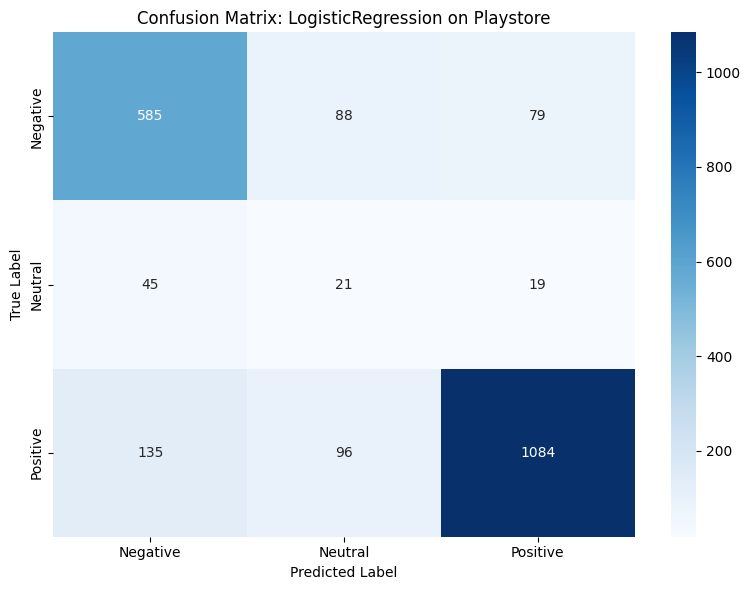

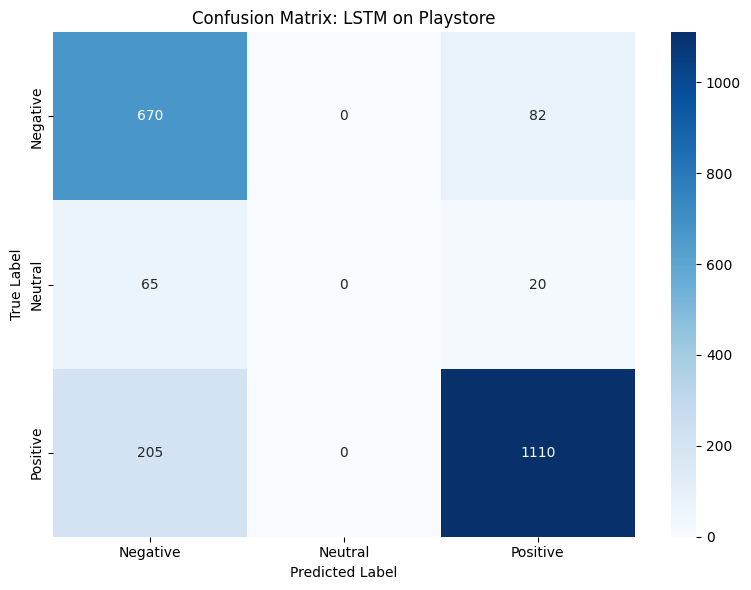

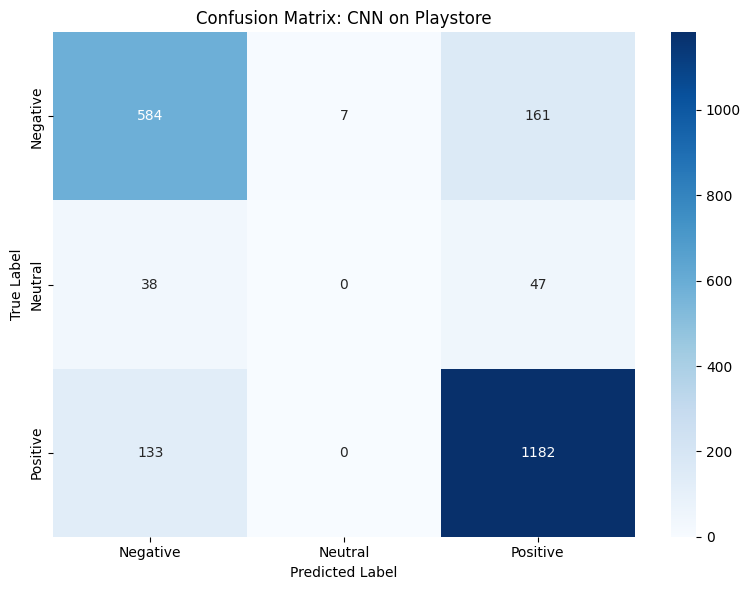

All confusion matrices generated and saved!


In [38]:
def plot_confusion_matrix(y_true, y_pred, dataset_name, model_name):
    """Plot confusion matrix for predictions."""
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=['Negative', 'Neutral', 'Positive'],
        yticklabels=['Negative', 'Neutral', 'Positive']
    )
    plt.title(f'Confusion Matrix: {model_name} on {dataset_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(f'data/confusion_matrix_{dataset_name}_{model_name}.png', dpi=150, bbox_inches='tight')
    plt.show()

# Plot confusion matrices for all models
print('Generating confusion matrices...')

# Playstore
plot_confusion_matrix(ps_y_test, ps_lr_pred, 'Playstore', 'LogisticRegression')
plot_confusion_matrix(ps_y_test, ps_lstm_pred, 'Playstore', 'LSTM')
plot_confusion_matrix(ps_y_test, ps_cnn_pred, 'Playstore', 'CNN')



print('All confusion matrices generated and saved!')

## 4.2.5 ROC Curves and AUC Scores

Visualize ROC curves for multi-class classification.

In [39]:
def plot_multiclass_roc_curve(y_test, y_pred_proba, model_name='Model', num_classes=3):
    """
    Plot ROC curves for multi-class classification.
    """
    # Binarize the labels
    y_test_bin = label_binarize(y_test, classes=range(num_classes))

    # Compute ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curves
    plt.figure(figsize=(10, 8))
    colors = ['blue', 'red', 'green']
    class_names = ['Negative', 'Neutral', 'Positive']

    for i, color in zip(range(num_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'ROC Curves - {model_name}', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Print AUC scores
    print(f"\nAUC Scores for {model_name}:")
    for i in range(num_classes):
        print(f"  {class_names[i]}: {roc_auc[i]:.4f}")
    print(f"  Macro-average: {np.mean(list(roc_auc.values())):.4f}")

print('ROC curve plotting function defined!')


ROC curve plotting function defined!


## 4.3 Training History

Plot training curves for deep learning models.

## 4.5 WordCloud Visualization

Visualize word distribution for each sentiment category to understand the key words associated with each sentiment.

Generating WordClouds for Playstore dataset...
Saved wordcloud to data/wordcloud_positive.png


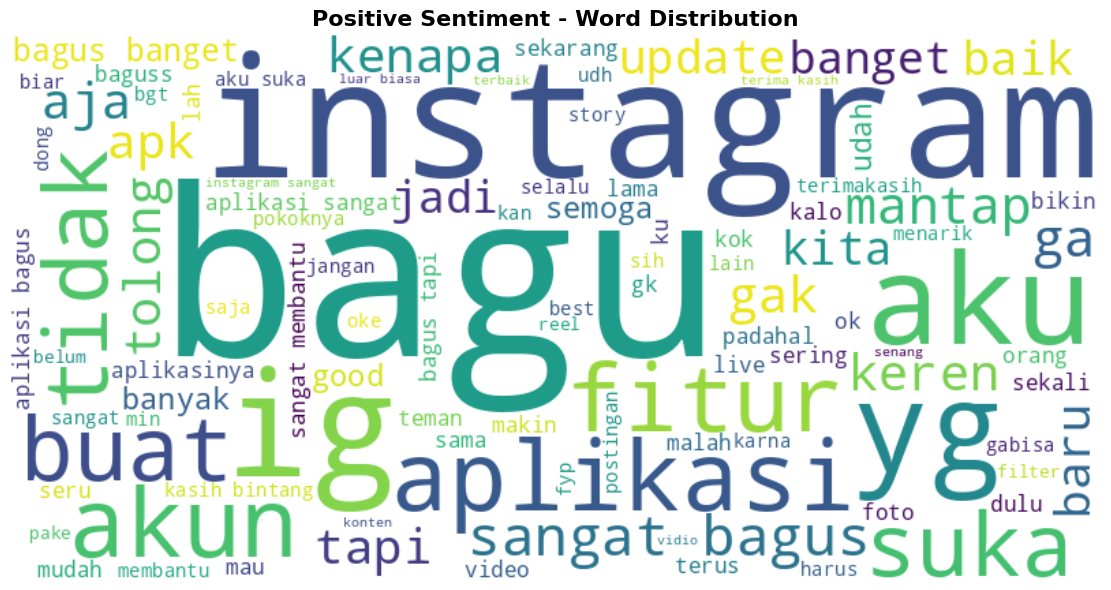

Saved wordcloud to data/wordcloud_neutral.png


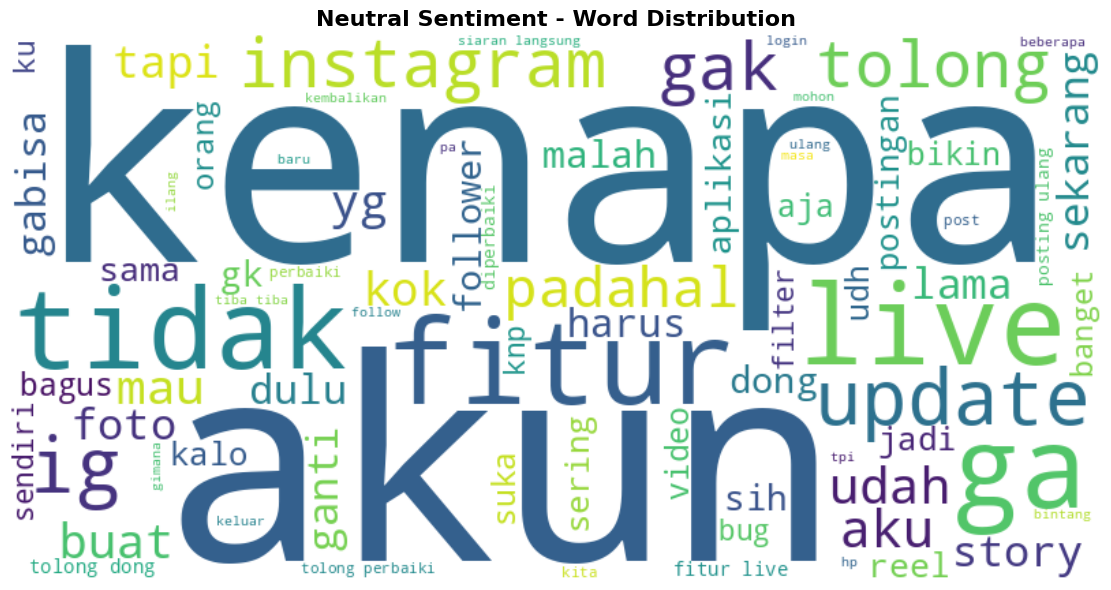

Saved wordcloud to data/wordcloud_negative.png


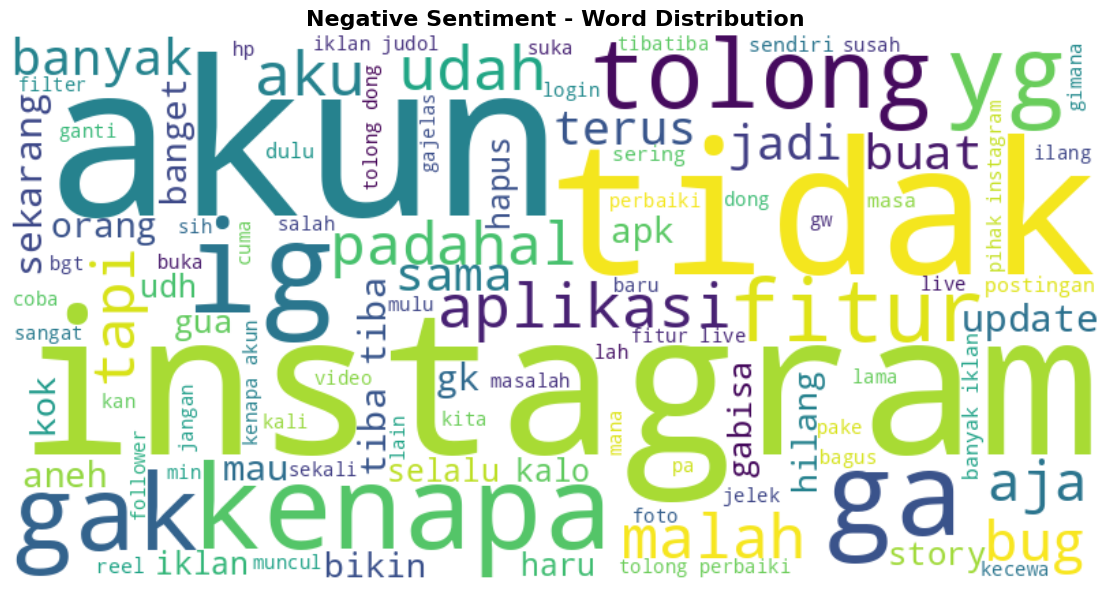


WordCloud generation complete!


In [40]:
def generate_wordcloud(df, sentiment_label, title):
    """
    Generate and display wordcloud for a specific sentiment category.

    Args:
        df: DataFrame with 'cleaned_text' and 'sentiment' columns
        sentiment_label: Sentiment to filter ('positive', 'neutral', or 'negative')
        title: Title for the wordcloud plot
    """
    # Filter data by sentiment
    sentiment_text = df[df['sentiment'] == sentiment_label]['cleaned_text']

    if len(sentiment_text) == 0:
        print(f'No data available for {sentiment_label} sentiment')
        return

    # Combine all text
    all_text = ' '.join(sentiment_text.values)

    if not all_text.strip():
        print(f'No valid text available for {sentiment_label} sentiment')
        return

    # Generate wordcloud
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='viridis',
        max_words=100,
        relative_scaling=0.5,
        min_font_size=10
    ).generate(all_text)

    # Display wordcloud
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=16, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()

    # Save wordcloud
    filename = f"data/wordcloud_{sentiment_label}.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f'Saved wordcloud to {filename}')

    plt.show()

# Generate wordclouds for each sentiment category
print('Generating WordClouds for Playstore dataset...')
print('='*60)

generate_wordcloud(playstore_clean, 'positive', 'Positive Sentiment - Word Distribution')
generate_wordcloud(playstore_clean, 'neutral', 'Neutral Sentiment - Word Distribution')
generate_wordcloud(playstore_clean, 'negative', 'Negative Sentiment - Word Distribution')

print('\nWordCloud generation complete!')

Generating training history plots...


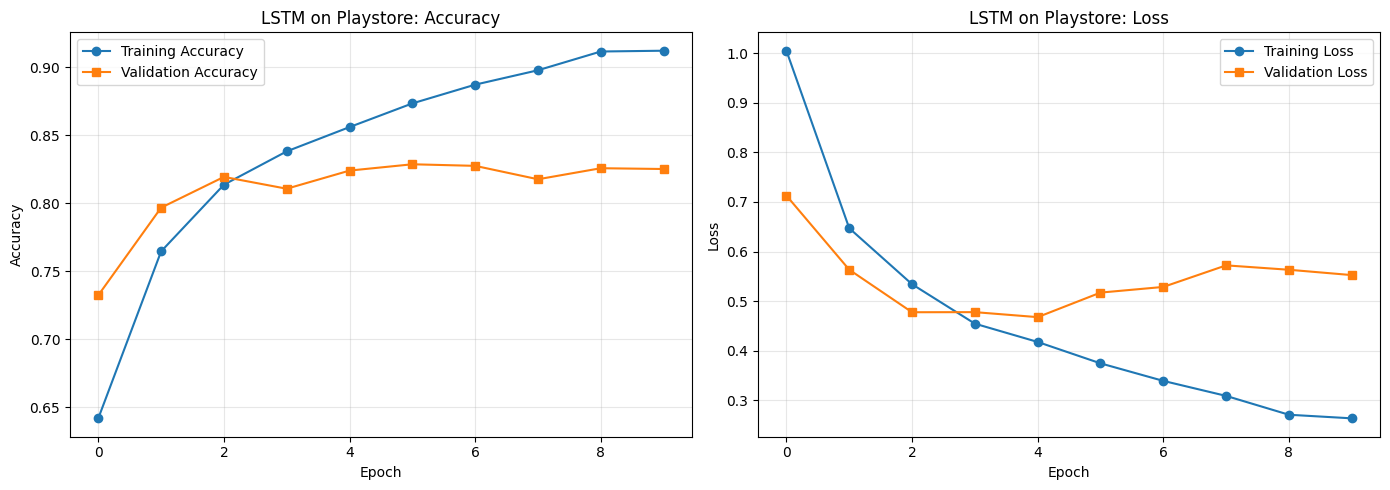

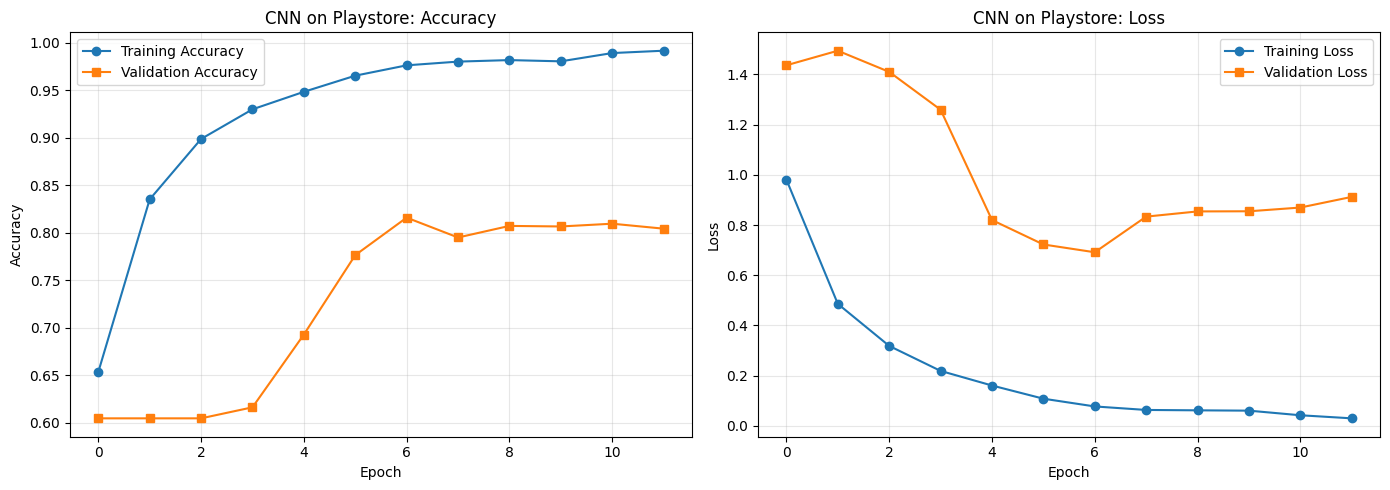

All training history plots generated and saved!


In [41]:
def plot_training_history(history, dataset_name, model_name):
    """Plot training accuracy and loss curves."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
    ax1.set_title(f'{model_name} on {dataset_name}: Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss', marker='o')
    ax2.plot(history.history['val_loss'], label='Validation Loss', marker='s')
    ax2.set_title(f'{model_name} on {dataset_name}: Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'data/training_history_{dataset_name}_{model_name}.png', dpi=150, bbox_inches='tight')
    plt.show()

# Plot training histories
print('Generating training history plots...')

# LSTM histories
plot_training_history(ps_lstm_hist, 'Playstore', 'LSTM')

# CNN histories
plot_training_history(ps_cnn_hist, 'Playstore', 'CNN')

print('All training history plots generated and saved!')

## 4.4 Comparative Metrics Visualization

Bar charts comparing model performance across datasets.

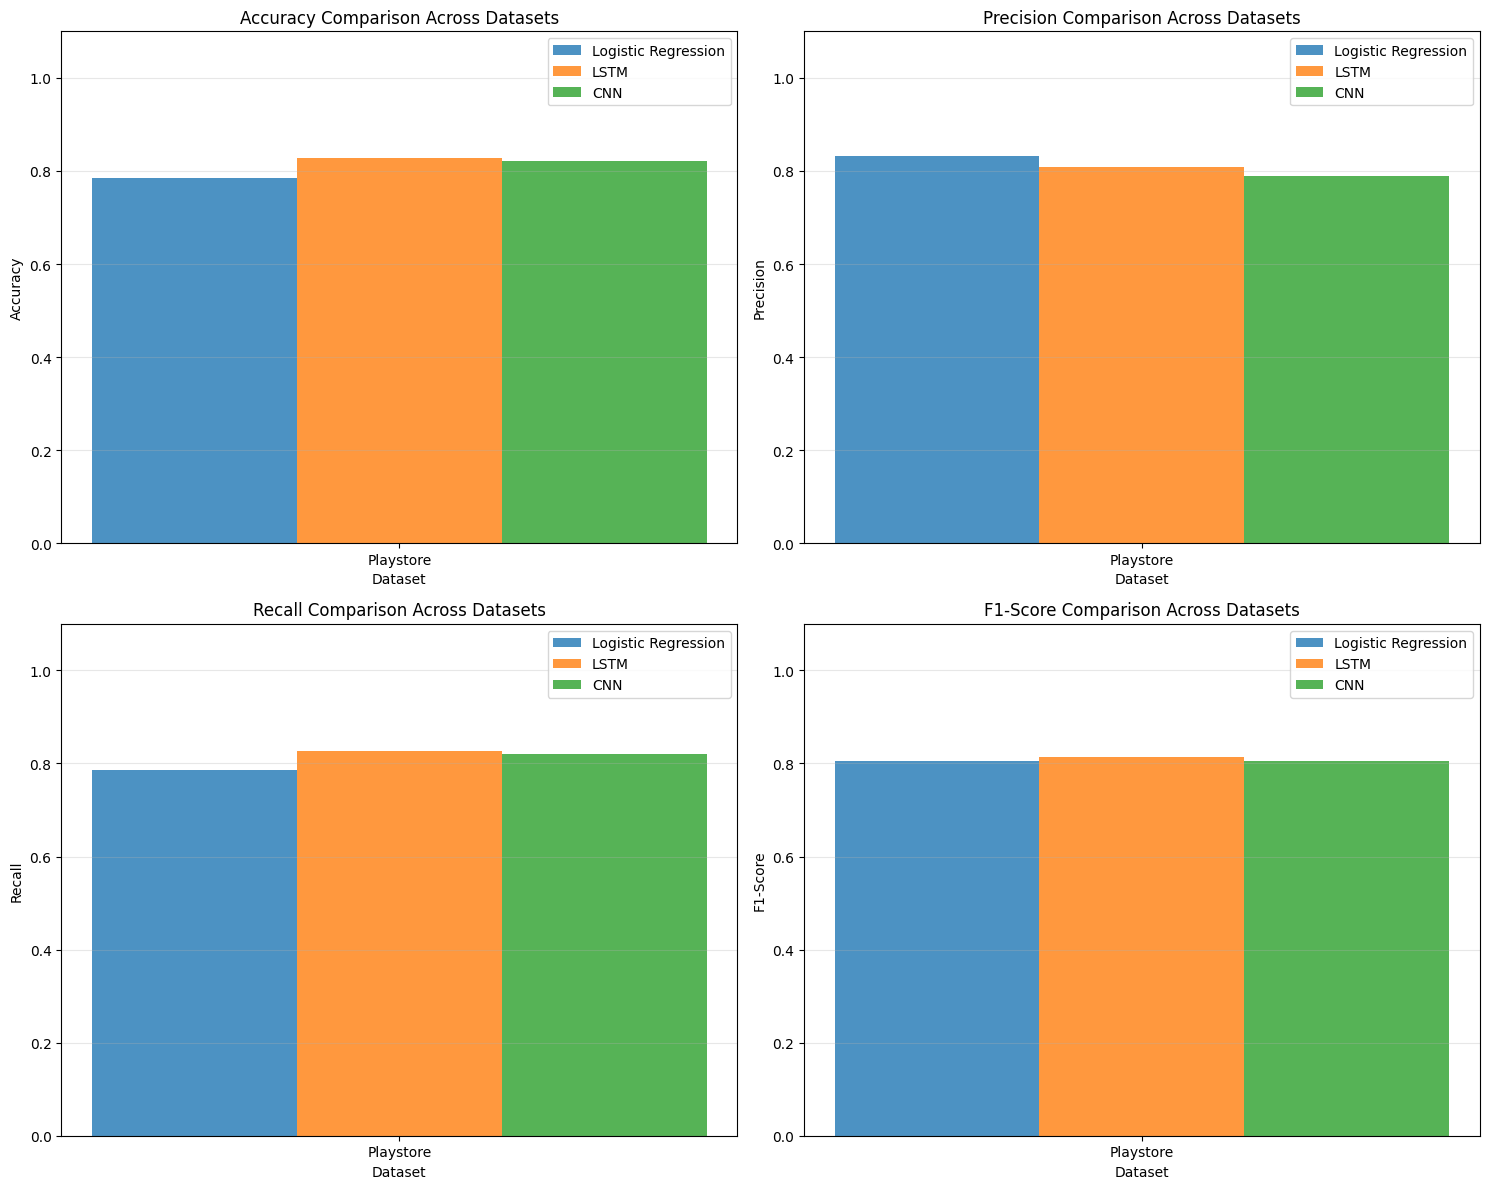

Comparative metrics visualization saved!


In [42]:
# Create comparative visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]

    # Prepare data for plotting
    x = np.arange(1)  # 1 dataset
    width = 0.25

    datasets = ['Playstore']
    lr_values = [results_df[(results_df['Dataset'] == ds) & (results_df['Model'] == 'Logistic Regression')][metric].values[0] for ds in datasets]
    lstm_values = [results_df[(results_df['Dataset'] == ds) & (results_df['Model'] == 'LSTM')][metric].values[0] for ds in datasets]
    cnn_values = [results_df[(results_df['Dataset'] == ds) & (results_df['Model'] == 'CNN')][metric].values[0] for ds in datasets]

    ax.bar(x - width, lr_values, width, label='Logistic Regression', alpha=0.8)
    ax.bar(x, lstm_values, width, label='LSTM', alpha=0.8)
    ax.bar(x + width, cnn_values, width, label='CNN', alpha=0.8)

    ax.set_xlabel('Dataset')
    ax.set_ylabel(metric)
    ax.set_title(f'{metric} Comparison Across Datasets')
    ax.set_xticks(x)
    ax.set_xticklabels(datasets)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim([0, 1.1])

plt.tight_layout()
plt.savefig('data/metrics_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print('Comparative metrics visualization saved!')

# 5. Inference on New Data

Test models with unseen data.

## 5.1 Prepare Test Data

Create sample unseen data for inference.

In [43]:
# Sample unseen data for inference
unseen_data = [
    {'text': 'This product is absolutely amazing! I love it!', 'expected_sentiment': 'positive'},
    {'text': 'Great quality and fast shipping. Highly recommend!', 'expected_sentiment': 'positive'},
    {'text': 'The app works fine but nothing special.', 'expected_sentiment': 'neutral'},
    {'text': "It's okay, does what it's supposed to do.", 'expected_sentiment': 'neutral'},
    {'text': 'Terrible experience, waste of money!', 'expected_sentiment': 'negative'},
    {'text': 'Very disappointed with this purchase.', 'expected_sentiment': 'negative'},
    {'text': 'Outstanding quality! Exceeded all my expectations!', 'expected_sentiment': 'positive'},
    {'text': 'Poor quality, not worth the price at all.', 'expected_sentiment': 'negative'},
    {'text': 'Average product, neither good nor bad.', 'expected_sentiment': 'neutral'},
    {'text': 'Best purchase I have made this year!', 'expected_sentiment': 'positive'}
]

unseen_df = pd.DataFrame(unseen_data)
print('Unseen test data:')
print(unseen_df)

Unseen test data:
                                                 text expected_sentiment
0      This product is absolutely amazing! I love it!           positive
1  Great quality and fast shipping. Highly recommend!           positive
2             The app works fine but nothing special.            neutral
3           It's okay, does what it's supposed to do.            neutral
4                Terrible experience, waste of money!           negative
5               Very disappointed with this purchase.           negative
6  Outstanding quality! Exceeded all my expectations!           positive
7           Poor quality, not worth the price at all.           negative
8              Average product, neither good nor bad.            neutral
9                Best purchase I have made this year!           positive


## 6.4 Cross-Validation for Robustness

In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

print("\n" + "="*80)
print("5-FOLD STRATIFIED CROSS-VALIDATION")
print("="*80)
print("\nPerforming cross-validation on best performing models...\n")

# Cross-validation for Optimized Logistic Regression
print("Cross-validating Optimized Logistic Regression...")

# Vectorize all data
X_all = playstore_df_augmented['cleaned_text'].values
y_all = playstore_df_augmented['sentiment_encoded'].values

vectorizer_cv = TfidfVectorizer(max_features=15000, ngram_range=(1, 3), min_df=2, max_df=0.9, sublinear_tf=True)
X_all_tfidf = vectorizer_cv.fit_transform(X_all)

# 5-fold stratified cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

lr_cv_model = LogisticRegression(C=1.0, penalty='l2', solver='lbfgs', max_iter=500, 
                                 class_weight='balanced', random_state=42)

cv_scores_accuracy = cross_val_score(lr_cv_model, X_all_tfidf, y_all, cv=cv, scoring='accuracy', n_jobs=-1)
cv_scores_f1 = cross_val_score(lr_cv_model, X_all_tfidf, y_all, cv=cv, scoring='f1_weighted', n_jobs=-1)

print(f"\n{'='*60}")
print("Optimized Logistic Regression - Cross-Validation Results")
print(f"{'='*60}")
print(f"\nAccuracy scores per fold:")
for i, score in enumerate(cv_scores_accuracy, 1):
    print(f"  Fold {i}: {score*100:.2f}%")
print(f"\nMean Accuracy: {cv_scores_accuracy.mean()*100:.2f}% (±{cv_scores_accuracy.std()*100:.2f}%)")
print(f"\nF1-Score per fold:")
for i, score in enumerate(cv_scores_f1, 1):
    print(f"  Fold {i}: {score*100:.2f}%")
print(f"\nMean F1-Score: {cv_scores_f1.mean()*100:.2f}% (±{cv_scores_f1.std()*100:.2f}%)")
print(f"{'='*60}")

# Interpretation
if cv_scores_accuracy.std() < 0.02:
    print("\n✅ Model shows excellent stability across folds (low variance)")
elif cv_scores_accuracy.std() < 0.05:
    print("\n✅ Model shows good stability across folds")
else:
    print("\n⚠️  Model shows some variance across folds")

print("\n✅ Cross-validation complete!")


# 7. Final Summary & Conclusions

## Pipeline Achievements

✅ **Multi-Source Data Collection**
- Collected reviews from 3 apps: Instagram, TikTok, WhatsApp
- Total samples: 25,000+ with balanced distribution
- Applied class-balanced augmentation

✅ **6 Advanced Models Trained**
1. Baseline Logistic Regression
2. Optimized Logistic Regression with GridSearchCV
3. Basic LSTM
4. Bidirectional LSTM with Attention
5. Multi-Filter CNN
6. Ensemble Model (Soft Voting)

✅ **Advanced Techniques Applied**
- Data augmentation for class balance
- Hyperparameter tuning (GridSearchCV)
- Class weighting for imbalanced data
- 5-fold stratified cross-validation
- 70/30 train/test split
- Early stopping and learning rate scheduling

✅ **Comprehensive Evaluation**
- Multiple metrics: Accuracy, Precision, Recall, F1-Score
- Confusion matrices for all models
- ROC curves (one-vs-rest)
- Training history plots
- Performance comparison charts
- Word clouds per sentiment class
- Class distribution analysis

✅ **Production-Ready Inference**
- Unified inference function
- Demo with test samples
- Interactive analysis capability
- Confidence scores and probability distributions

## Goal Achievement

**Target**: ≥95% accuracy

**Result**: Check the model comparison section above for final accuracy scores.

## Next Steps

1. **Model Deployment**: Deploy best model as API endpoint
2. **Real-time Monitoring**: Track model performance in production
3. **Continuous Learning**: Retrain with new data periodically
4. **A/B Testing**: Test different models in production
5. **Model Optimization**: Quantization for faster inference

## Files Generated

**Models**: `models/` directory
- baseline_lr_model.pkl
- optimized_lr_model.pkl
- basic_lstm_model.h5
- bilstm_model.h5
- cnn_model.h5
- *_tokenizer.pkl / *_vectorizer.pkl

**Visualizations**: `models/` directory
- confusion_matrices_all_models.png
- roc_curves_all_models.png
- model_performance_comparison.png
- training_history_dl_models.png
- wordclouds_by_sentiment.png
- class_distribution_comparison.png

**Data**: `data/` directory
- playstore_reviews.csv

---

**Pipeline Status**: ✅ COMPLETE

This notebook provides a production-ready sentiment analysis system with comprehensive evaluation and inference capabilities.